In [97]:
import math
import numpy as np
import random
from matplotlib import pyplot as plt 
from tqdm import tqdm
import copy
import csv

#locations are currently implemented in terms of grid quadrants where
#quad 0 = (range(0, 50), range(0, 50))
#quad 1 = (range(0, 50), range(50, 100))
#quad 2 = (range(50, 100), range(0, 50))
#quad 3 = (range(50, 100), range(50, 100))
            

def initialise_ISPs(StartingMarket, InitialMoneyPool):
    '''
    function to reset ISP attributes to their initial parameters according to the starting market selected
    
    Starting markets include:
        super realistic: based on current (as of Apr 23 2023) plans available on the market
        simplified realsitic: translates ^ into a more simplified version that simplifies the market
        pre_NBN: taken as a stating market with low levels of competition
        idealsitic: highly competitve, equal-access ideal market 
    '''
    
    # begin by using the correct data-importing funtion
    if StartingMarket == "super_realistic":
        plans = initialise_ISPs_super_realistic()
    elif StartingMarket == "simplified_realistic":
        plans = initialise_ISPs_super_realistic()
        plans = initialise_ISPs_simplified_realistic(plans)
    elif StartingMarket == "pre_NBN":
        plans = initialise_ISPs_pre_NBN()
    elif StartingMarket == "idealistic":
        plans = initialise_ISPs_idealistic()
    else:
        print("ERROR: please provide a valid input as a starting market either:\n - 'super_realistic'\n - 'simplified_realistic'\n - 'pre_NBN'\n - 'idealistic'")
    
    # convert the CSV strings to the correct data type
    for i in range(len(plans)):
        row = plans[i]
        plans[i] = [row[0], row[1], float(row[2]), row[3], float(row[4]), row[5]]
    
    # initialising the data structure for all the ISPs and ISPs-per-location
    separated_plans = separate_plans_by_ISP(plans)
    initial_profits = get_initial_profits(StartingMarket)
    ISPs = create_ultimate_list_of_ISPs(separated_plans, initial_profits, InitialMoneyPool)
    operator_locations = define_ISPs_per_location(ISPs)
    return ISPs, operator_locations


def separate_plans_by_ISP(plans):
    '''function which takes a list of internet plans and turns it into a list of lists of plans
    where each inner list is the plans for one specific internet provider'''
    current_provider = plans[0][0]
    current_provider_plans = []
    separated_plans_list = []
    for row in plans:
        if row[0] == current_provider:
            current_provider_plans.append(row)
        else:
            separated_plans_list.append(current_provider_plans)
            current_provider_plans = [row]
            current_provider = row[0]
    separated_plans_list.append(current_provider_plans)
    return separated_plans_list


def create_ultimate_list_of_ISPs(separated_plans, initial_profits, InitialMoneyPool):
    '''
    Function to create the data structure for storing all the ISP info
    
    Entries in the ISP list have the form:
        [0: ISP name (string), 
        1: plans offered (list), 
        2: mobile offered? (bool),
        3: mobile locations offered (list or None),
        4: wifi offered? (bool),
        5: wifi locations offered (list or None),
        6: currently in price experiment? (False or list),
        7: currently in tech experiment? (False or list),
        8: monthly profit (float)
        9: moneypool]
        
    Every plan in the list of plans offered has the form:
        [0: ISP name (string),
        1: service type ('mobile' or 'wifi'),
        2: speed or GB float (speed if 'wifi' ^, GB if 'mobile' ^)
        3: locations available (string)
        4: price ($ per month)
        5: wholesale supplier]
    '''
    
    ISPs = []
    
    for i in range(len(separated_plans)):
        ISP = separated_plans[i][0][0]
        plans_offered = separated_plans[i]
        
        mobile_offered = (plans_offered[0][1] == "mobile")
        if mobile_offered:
            mobile_locations_offered = translate_footprints_into_quads(plans_offered, True)
        else:
            mobile_locations_offered = None
        
        wifi_offered = (plans_offered[-1][1] == "wifi")
        if wifi_offered:
            wifi_locations_offered = translate_footprints_into_quads(plans_offered, False)
        else:
            wifi_locations_offered = None
        
        price_exp = False
        tech_exp = False
        profit = initial_profits[i] 
        moneypool = InitialMoneyPool 
        
        ISP_data = [ISP, plans_offered, mobile_offered, mobile_locations_offered, wifi_offered, wifi_locations_offered, price_exp, tech_exp, profit, moneypool]
        ISPs.append(ISP_data)
    
    return ISPs 


def translate_footprints_into_quads(plans, mobile):
    '''function which translates input location strings "urban", "regional" and "remote", into the quadrants
    that service would cover in footprint.'''
    total_locations_operational = []
    for p in plans:
        if not mobile and p[1] == "wifi":
            location = p[3]
            if location == "remote":
                if not 3 in total_locations_operational:
                    total_locations_operational.append(3)
                if not 1 in total_locations_operational:
                    total_locations_operational.append(1) #satellite assumed to be avail in regional areas too 
                    total_locations_operational.append(2)
            elif location == "regional":
                if not 1 in total_locations_operational:
                    total_locations_operational.append(1)
                    total_locations_operational.append(2)
            else:
                if not 0 in total_locations_operational:
                    total_locations_operational.append(0)
        elif mobile and p[1] == "mobile":
            location = p[3]
            if location == "remote":
                total_locations_operational = [0, 1, 2, 3]
                break
            elif location == "regional":
                total_locations_operational = [0, 1, 2]
            else:
                total_locations_operational = [0]
    total_locations_operational.sort()
    return total_locations_operational                          


def define_ISPs_per_location(ISPs):
    ''' 
    creating a 2d array where each element in the outer array is a list for the location (quadrant), 
    and those lists are made up of numbers referring to the indexes of an ISP in ISPs that operates
    in said location.
    '''
    
    operator_locations = [[], [], [], []]
    
    for i in range(len(ISPs)):
        if ISPs[i][4] == True:
            for quad in ISPs[i][5]:
                operator_locations[quad].append(i)
        if ISPs[i][2] == True:
            for quad in ISPs[i][3]:
                operator_locations[quad].append(i)
                    
    # Remove duplicates
    for quad in operator_locations:
        i = 0
        while i < len(quad):
            j = i + 1
            while j < len(quad):
                if quad[i] == quad[j]:
                    del quad[j]  # Remove the duplicate element
                else:
                    j += 1
            i += 1
                        
    return operator_locations


def get_initial_profits(StartingMarket):
    #market share data is used as a proxy for the intial profit
    market_shares = get_market_share_data(StartingMarket)
    avg_shares = []
    for company in market_shares:
        avg_shares.append(float(company[3]))
    total = sum(avg_shares)
    profits = [share / total for share in avg_shares]
    return profits


def get_market_share_data(StartingMarket):
    if StartingMarket == "super_realistic":
        shares = []
        with open("../data_files/market/isp_market_shares.csv", "r") as file:
            csvreader = csv.reader(file)
            header = next(csvreader)
            for row in csvreader:
                shares.append(row)
        return shares


def initialise_ISPs_super_realistic():
    '''opens and saves a csv data file with real-world plan data as of 23 April 2024'''
    plans = []
    with open("../data_files/market/plans_data/realistic_plans_data.csv", 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            plans.append(row)
    return plans


def initialise_ISPs_pre_NBN():
    '''opens and saves a csv data file with pre-NBN plan data as example of low-competition market'''
    plans = []
    with open("../data_files/market/plans_data/pre_NBN_plans_data.csv", 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            plans.append(row)
    return plans


def initialise_ISPs_idealistic():
    '''opens and saves a csv data file with plan data which reflects idealistically competitive market'''
    plans = []
    with open("../data_files/market/plans_data/idealistic_plans_data.csv", 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            plans.append(row)
    return plans


def prep_bundles(person, ISPs, TimeBudget, MarketingBudget, operator_locations, Seed):
    '''stage 3 of the decsion making process where a person prepares their bundles (analagous to research)'''
    global add_to_seed
    
    y = person[0][0]
    x = person[0][1]
    if x < 50:
        if y < 50:
            quad = 0
        else:
            quad = 1
    else:
        if y < 50:
            quad = 2
        else:
            quad = 3 
    
    # establishing the operators available in their location (who's website should I look at?)
    mobile_operators, wifi_operators = pick_operators(ISPs, quad, operator_locations, TimeBudget, MarketingBudget, Seed)    
    
    # establishing the bundles physically available (which plans on the website are relevant?)
    mobile_plans = []
    wifi_plans = []
    bundles = []
    
    if len(wifi_operators) == 0:
        print("THIS HAPPENED")
        
    for m in range(len(mobile_operators)):
        for plan in mobile_operators[m][1]:
            if plan[1] == "mobile" and plan_available_in_my_area(plan, quad):
                mobile_plans.append(plan)
    for w in range(len(wifi_operators)):
        for plan in wifi_operators[w][1]:
            if plan[1] == "wifi" and plan_available_in_my_area(plan, quad):
                wifi_plans.append(plan)
    for m in range(len(mobile_plans)):
        for w in range(len(wifi_plans)):
            bundles.append((mobile_plans[m], wifi_plans[w]))
            
    if len(mobile_plans) == 0:
        print("THIS HAPPENED INSTEAD")
    if len(wifi_plans) == 0:
        print("ACTUALLY ITS WIFI FAM")
        print("person:", person)
        print("quad:", quad)
        for plan in wifi_operators[w][1]:
            if plan[1] == "wifi": 
                print(plan)
                print(plan_available_in_my_area(plan, quad))
    if len(bundles) == 0:
        print("AND ACCORDINGLY")
    
    return bundles, mobile_plans, wifi_plans


def plan_available_in_my_area(plan:list, quad:int):
    if plan[0] == "PLAN GONE":
        return False
    footprint = plan[3]
    if plan[1] == "wifi":
        if quad == 0 and footprint == "urban":
            return True
        if quad == 1 or quad == 2 and footprint == "regional":
            return True
        if quad != 0 and footprint == "remote":
            return True
    else:
        if footprint == "remote":
            return True
        if footprint == "regional" and quad != 3:
            return True
    return False


def pick_operators(ISPs:list, quad:int, operator_locations:list, TimeBudget:int, MarketingBudget:float, Seed:int):
    '''function which biased-randomly picks ISPs for a person agent to consider plans from'''
    
    global add_to_seed
    selected_mobile_operators = []
    selected_wifi_operators = []
    indexes = [] 
    choices = operator_locations[quad]
    
    marketing_budgets = []
    industry_total = 0
    for choice in choices:
        if ISPs[choice][8] <= 0:
            marketing_budget = MarketingBudget * ISPs[choice][9] #if they experiences no profits marketing money comes out of their savings
        else:
            marketing_budget = MarketingBudget * ISPs[choice][8] #if they experienced profits marketing money comes from profits
        marketing_budgets.append(marketing_budget)
        industry_total += marketing_budget
        
    pr_effective_marketing = []
    for budget in marketing_budgets:
        pr = budget/industry_total #normalisation
        round_up_to_nearest_001(pr) #setting a minimum probability threshhold
        pr_effective_marketing.append(pr)
    pr_effective_marketing = ensure_adds_to_1(pr_effective_marketing, Seed) #incase there are errors in rounding 
        
    if TimeBudget > len(choices): 
        TimeBudget = len(choices) #avoids infinite loop below
    
    while TimeBudget > 0:
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        choice = random.choices(range(len(choices)), weights=pr_effective_marketing, k=1)[0] #probability of an ISP being chosen is proportional to that ISP's marketing budget
        index = choices[choice]
        if ISPs[index][2] and quad in ISPs[index][3]:
            selected_mobile_operators.append(ISPs[index])
            if ISPs[index][4] and quad in ISPs[index][5]:
                selected_wifi_operators.append(ISPs[index])
            TimeBudget -= 1
        elif ISPs[index][4] and quad in ISPs[index][5]:
            selected_wifi_operators.append(ISPs[index])
            TimeBudget -= 1
        
        # Remove the choice from choices and re-normalise probabilities
        choices = choices[:choice] + choices[choice+1:]
        pr_effective_marketing = pr_effective_marketing[:choice] + pr_effective_marketing[choice+1:]
        pr_sum = sum(pr_effective_marketing)
        pr_effective_marketing = [p / pr_sum for p in pr_effective_marketing]
    
    #handelling for if the chosen lists end up different sizes with wifi with less
    while len(choices) > 0 and len(selected_mobile_operators) > len(selected_wifi_operators):
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        choice = random.choices(range(len(choices)), weights=pr_effective_marketing, k=1)[0] #probability of an ISP being chosen is proportional to that ISP's marketing budget
        index = choices[choice]
        if ISPs[index][4] and quad in ISPs[index][5]:
            selected_wifi_operators.append(ISPs[index])    
        # Remove the choice from choices and re-normalise probabilities
        choices = choices[:choice] + choices[choice+1:]
        pr_effective_marketing = pr_effective_marketing[:choice] + pr_effective_marketing[choice+1:]
        pr_sum = sum(pr_effective_marketing)
        pr_effective_marketing = [p / pr_sum for p in pr_effective_marketing] 
    
    #handelling for if the chosen lists end up different sizes with mobile with less
    while len(choices) > 0 and len(selected_mobile_operators) < len(selected_wifi_operators):
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        choice = random.choices(range(len(choices)), weights=pr_effective_marketing, k=1)[0] #probability of an ISP being chosen is proportional to that ISP's marketing budget
        index = choices[choice]
        if ISPs[index][2] and quad in ISPs[index][3]:
            selected_mobile_operators.append(ISPs[index]) 
        # Remove the choice from choices and re-normalise probabilities
        choices = choices[:choice] + choices[choice+1:]
        pr_effective_marketing = pr_effective_marketing[:choice] + pr_effective_marketing[choice+1:]
        pr_sum = sum(pr_effective_marketing)
        pr_effective_marketing = [p / pr_sum for p in pr_effective_marketing] 

    return selected_mobile_operators, selected_wifi_operators


def ensure_adds_to_1(probs_array, Seed):
    '''Simple function to ensure the probabilities in an array always add up to 1'''
                     
    global add_to_seed
    total = sum(probs_array)
    if total == 1:
        return probs_array
    if total < 1: #happens very very rarely due to python's rounding to like 32 bits or whatever
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        add_to_me = random.randint(0, len(probs_array) - 1)
        amount_under = 1 - total #garunteed to be a tiiiiiny number
        probs_array[add_to_me] += amount_under
        return probs_array
    amount_over = total - 1
    while amount_over > 0: #should be a tiny number which is a scalar multiple of 0.001 (the minimum probability threshhold)
        for p in range(len(probs_array)):
            if probs_array[p] > 0.001:
                if amount_over > 0.001:
                    probs_array[p] -= 0.001
                    amount_over - 0.001
                else:
                    probs_array[p] -= amount_over
                    return probs_array


def round_up_to_nearest_001(number):
    if number > 0:
        return ((number + 0.0005) // 0.001) * 0.001
    else:
        return ((number - 0.0005) // 0.001) * 0.001
    
    
def decide_bundle(person, complete_bundles, mobile_plans, wifi_plans, PrSacrificeWifi, IncomeBudget, Seed, initial_call=False):
    '''function which chooses a person's bundle from a prepared set of options'''
    
    global add_to_seed
    #preference is to choose a complete bundle
    chosen_bundle = decision_tree(person, complete_bundles, IncomeBudget, initial_call)
    if chosen_bundle != None:
        if chosen_bundle == 'no change':
            return person[3]
        return complete_bundles[chosen_bundle]
    
    else:
        chosen_mobile_plan = "dummy"
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        if random.random() < PrSacrificeWifi: 
            #try to choose a mobile plan
            chosen_mobile_plan = decision_tree(person, mobile_plans, IncomeBudget, initial_call)
            if chosen_mobile_plan != None:
                if chosen_mobile_plan == 'no change':
                    return person[3]
                return (mobile_plans[chosen_mobile_plan], None)
        
        #try to choose a wifi plan
        chosen_wifi_plan = decision_tree(person, wifi_plans, IncomeBudget, initial_call)
        if chosen_wifi_plan != None:
            if chosen_wifi_plan == 'no change':
                return person[3]
            return (None, wifi_plans[chosen_wifi_plan])
        
        #if we haven't already tried choosing a mobile plan
        if chosen_mobile_plan == "dummy":
            chosen_mobile_plan = decision_tree(person, mobile_plans, IncomeBudget, initial_call)
            if chosen_mobile_plan != None:
                if chosen_mobile_plan == 'no change':
                    return person[3]
                return (mobile_plans[chosen_mobile_plan], None)
            
    return (None, None)


def decision_tree(person, bundles, IncomeBudget, initial_call):
    '''function which replicates the decsion-tree logic to choose the best bundle from a list of options, 
    returning the index of that bundle'''
    
    if len(bundles) == 0: #early return if nothing to choose from
        return None
    
    global timser
    
    bundle_evaluation_list = create_bundle_eval_list(bundles)
    
    x = person[0][1]
    y = person[0][0]
    if x < 50:
        if y < 50:
            quad = 0
        else:
            quad = 1
    else:
        if y < 50:
            quad = 2
        else:
            quad = 3
    income = person[2]
    
    #intitalising current in different circumstances
    if initial_call or person[3] == (None, None):
        current_best = (1000000000, 0, -1) #dummy bundle tuple
    elif isinstance(bundles[0], tuple) and (person[3][0] == None or person[3][1] == None):
        current_best = (1000000000, 0, -1) #dummy bundle tuple
    elif (person[3][0] == None and bundles[0][1] == "mobile") or (person[3][1] == None and bundles[0][1] == "wifi"):
        current_best = (1000000000, 0, -1) #dummy bundle tuple
    else: #turn current into bundle_eval_list tuple
        if person[3][0] == None:
            current_best = create_bundle_eval_list([person[3][1]])[0] #current is wifi-only
        elif person[3][1] == None:
            current_best = create_bundle_eval_list([person[3][0]])[0] #current is mobile-only
        else:
            current_best = create_bundle_eval_list([person[3]])[0] #current is complete bundle
    current_best_index = -1
    
    #the decsion tree processing 
    for new_bundle in range(len(bundle_evaluation_list)):
        current_best_cost = current_best[0]
        current_best_value = current_best[1]
        current_best_middleness = current_best[2]
        new_cost = bundle_evaluation_list[new_bundle][0]
        new_value = bundle_evaluation_list[new_bundle][1]
        new_middleness = bundle_evaluation_list[new_bundle][1]

        if new_cost/income < IncomeBudget: #is the bundle under budget?
            if current_best_cost/income >= 0.05: #is current >= 5% of income?
                if new_cost < current_best_cost: #is new bundle cheaper?
                    current_best = bundle_evaluation_list[new_bundle]
                    current_best_index = new_bundle
            else:
                if new_cost/income < 0.05: #is new bundle < 5% of income?
                    if (new_cost/income <= 0.02) and (new_value > current_best_value): #is new bundle <= 2% of income and better value?
                        current_best = bundle_evaluation_list[new_bundle]
                        current_best_index = new_bundle
                    else:
                        if new_middleness > current_best_middleness : #pick the middle?
                            current_best = bundle_evaluation_list[new_bundle]
                            current_best_index = new_bundle
    
    #handeling for when a person experiences 'internet proverty' (can't afford any bundle)
    if current_best_index == -1 and current_best[0] == 'dummy':
        return None
    
    #handeling for if prices have increased since user last checked thier plan, but it was still better than everything else
    if current_best_index == -1:
        if current_best[0]/income > IncomeBudget:
            return None
        else:
            return "no change"
        
    return current_best_index


def create_bundle_eval_list(bundles:list):
    '''turning a list of bundles into a bundle_evaluation_list for decsion tree processing'''
    
    global timser
    
    bundle_evaluation_list = []
    speeds = [12, 25, 50, 100, 1000] #last one is just 250+
    
    temp_wifi_values = [0] * len(bundles)
    for b in range(len(bundles)):
        if isinstance(bundles[0], tuple):
            if bundles[b][1] != None:
                for speed in range(len(speeds)):
                    if bundles[b][1][2] <= speeds[speed]:
                        temp_wifi_values[b] = speed + 1
                        break
        elif bundles[b][1] == "wifi":
            for speed in range(len(speeds)):
                if bundles[b][2] <= speeds[speed]:
                    temp_wifi_values = speed + 1
                    break
    
    if isinstance(bundles[0], tuple): 
        max_GB = 0
        max_data_price = 0
        max_Mbps = 0
        for bundle in bundles:
            if bundle[0][2] > max_GB:
                max_GB = bundle[0][2]
            if bundle[0][4] > max_data_price:
                max_data_price = bundle[0][4]
            if bundle[1][2] > max_Mbps:
                max_Mbps = bundle[1][2]
        
        for b in range(len(bundles)):
            bundle = bundles[b]
            price = bundle[0][4] + bundle[1][4]
            norm_GB = bundle[0][2]/max_GB
            norm_data_price = bundle[0][4]/max_data_price
            norm_Mbps = temp_wifi_values[b]/5
            value = (norm_GB + norm_Mbps)/2 #0-1 standarised avg value
            price_GB_avg = (norm_GB + norm_data_price)/2
            middleness_GB = -timser*((price_GB_avg - 0.5)**2) + 1
            middleness_Mbps = -timser*((norm_Mbps - 0.5)**2) + 1
            middleness = (middleness_GB + middleness_Mbps)/2 #avg of how close the two plans are to being the median plan
            #print("GB:", bundle[0][2], "norm_GB:", bundle[0][2]/max_GB, "Mbps:", bundle[1][2], "norm_Mbps:", temp_wifi_values[b]/5, "mid:", middleness)
            bundle_evaluation_list.append((price, value, middleness))
    
    else:
        max_value = 0
        for plan in bundles:
            if plan[2] > max_value:
                max_value = plan[2]
                
        for plan in bundles:
            price = plan[4]
            value = plan[2]/max_value #standardise value
            middleness = -4*(value - 0.5)**2 + 1
            bundle_evaluation_list.append((price, value, middleness))
    
    return bundle_evaluation_list 


# intialisation helper functions

def decide_if_populated(location: tuple, Seed:int):
    '''
    function which randomly decides if a grid-square is populated (1) 
    or empty (0), with probability depending on location, to simulate city 
    vs rural population density.
    '''
    global add_to_seed
    y = location[0]
    x = location[1]
    random.seed(Seed + add_to_seed)
    add_to_seed += 23
    num = random.random()     
    
    if x < 50 and y < 50: #urban
        if num < 0.8:
                return True
    elif x >= 50 and y >= 50: #remote
        if num < 0.07:
                return True
    else: #regional
        if num < 0.15: 
                return True
    return False
            

def initialise_income(location: tuple, Seed:int):
    '''
    Randomly samples income based on location by assigning agents to a quartile (based on average LGA 
    income quartile data across different remoteness areas), and using national quartile ranges from ABS 
    to sample the income from within a quartile's range
    '''
    global add_to_seed
    y = location[0]
    x = location[1]
    
    if x < 50 and y < 50: #urban
        probabilities = [0.238, 0.235, 0.239, 0.288] #see the determined avg income per remoteness area file
    elif x >= 50 and y >= 50: #remote
        probabilities = [0.294, 0.246, 0.237, 0.223]
    else: #regional
        probabilities = [0.287, 0.268, 0.246, 0.199]
    quartiles = [1, 2, 3, 4]
    random.seed(Seed + add_to_seed)
    add_to_seed += 23
    quartile = random.choices(quartiles, weights=probabilities, k=1)[0]
    
    random.seed(Seed + add_to_seed)
    add_to_seed += 23
    if quartile == 1:
        income = random.uniform(381, 2594) #lowerbound taken as the centrelink JobSeeker amount for single, no children people
    elif quartile == 2:
        income = random.uniform(2595, 3838)
    elif quartile == 3:
        income = random.uniform(3839, 5602)
    elif quartile == 4:
        income = random.uniform(5603, 15000) #upperbound is just above the 95% percentile for taxable income in 2019
    
    return income


def decide_expenditure(bundle: tuple, income: int):
    '''simple little function determing the percentage a person is spending on internet based on thier bundle'''
    if bundle == (None, None): #no connection
        return None 
    elif bundle[0] == None: #wifi only
        return bundle[1][4] / income * 100 
    elif bundle[1] == None: #mobile only
        return bundle[0][4] / income * 100
    else: 
        return (bundle[0][4] + bundle[1][4]) / income * 100
    
    
def initialise_grid(TimeBudget:int, IncomeBudget:float, MarketingBudget:float, PrSacrificeWifi:float, Seed:int):  
    '''function to create an initial grid of 100x100 dimension, where each (filled) 
    cell is an agent that with atrributes:
        
        [0: location: tuple, 
        1: populated status: bool, 
        2: monthly income: int ($), 
        3: internet bundle: tuple (mobile plan, wifi plan) 
        4: percentage income spent on bundle: float%]
    
    Time complexity: O(width x height x TimeBudget^2 x max_plans_per_provider_per_location) ~= 50000 * timexc.p-0
    '''
    global add_to_seed
    grid = np.zeros((100, 100, 6), dtype=object) #init the grid as a 3D np array
    
    # Populating the grid
    for row in tqdm(range(100)):
        for cell in range(100):
            location = (row, cell)
            is_populated = decide_if_populated(location, Seed)
            grid[row, cell, 0] = location
            grid[row, cell, 1] = is_populated
            
            if is_populated:
                income = initialise_income(location, Seed)
                complete_bundles, mobile_plans, wifi_plans = prep_bundles([location, True, income, (None, None), None], ISPs, TimeBudget, MarketingBudget, operator_locations, Seed)
                bundle = decide_bundle([location, True, income, (None, None), None], complete_bundles, mobile_plans, wifi_plans, PrSacrificeWifi, IncomeBudget, Seed, True)
                percent_spent_on_bundle = decide_expenditure(bundle, income)
                
                grid[row, cell, 2] = income
                grid[row, cell, 3] = bundle
                grid[row, cell, 4] = percent_spent_on_bundle
            
    return grid



def plotting_func(colouring_desired):
    fig, ax = plt.subplots()
    ax.imshow(np.zeros((100, 100)), cmap='gray')  # Initialising grid with grey
    colours_for_later = []
    
    if colouring_desired == "income":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 2] <= 2594:
                        color = 'orangered'
                    elif grid[row, cell, 2] <= 3838:
                        color = 'lightpink'
                    elif grid[row, cell, 2] <= 5602:
                        color = 'lightsteelblue'
                    elif grid[row, cell, 2] > 5602:
                        color = 'blue'
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by income quartile")
        legend = "red = quartile 1 ($1525 - $2594)\npink = quartile 2 ($2595 - $3838)\nlight blue = quartile 3 ($3839 - $5602)\ndark blue = quartile 4 ($5603-$12000)"
        
    elif colouring_desired == "affordability_stress_status":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 4] == None:
                        color = "red"
                    elif grid[row, cell, 4] >= 5:
                        color = 'orange'
                    elif grid[row, cell, 4] < 5:
                        color = 'lightgreen'
                    else:
                        print("ERROR: unmatched percent spent -", grid[row, cell, 4])
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by affordability stress status")
        legend = "green = no stress\norange = affordability stress\nred = internet poverty (no connection)"
    
    elif colouring_desired == "wifi_tech_type":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][1] == None:
                        if grid[row, cell, 3][0] == None:
                            color = 'red'
                        else:
                            color = 'lightsalmon'
                    elif grid[row, cell, 3][1][3] == 'urban':
                        color = 'lightskyblue'
                    elif grid[row, cell, 3][1][3] == 'regional':
                        color = 'blue'
                    elif grid[row, cell, 3][1][3] == 'remote':
                        color = 'blueviolet'
                    else:
                        print("ERROR: unmatched tech type - '", grid[row, cell, 3][1][3])
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by NBN home broadband tech type")
        legend = "LEGEND:\nlight blue = wired\ndark blue = fixed wireless\npurple = satellite\nsalmon = mobile only\nred = no connection"
        
    elif colouring_desired == "bundle_type":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3] == (None, None):
                        color = "red"
                    elif grid[row, cell, 3][1] == None:
                        color = "fuchsia"
                    elif grid[row, cell, 3][0] == None:
                        color = "aqua"
                    else:
                        color = "greenyellow"
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by bundle type")
        legend = "LEGEND:\ngreen = both mobile and home wifi\naqua = wifi only\nfuchsia = mobile only\nred = no connection"
        
    elif colouring_desired == "mobile_ISP":
        colours = ["lightblue", "gold", "yellow", "red", "blueviolet", "green", "lightsalmon", "fuchsia", "blue", "orange", "crimson", "lime", "brown", "aqua", "grey", "peru"]
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][0] == None:
                        color = "white"
                    else:
                        for i in range(len(ISPs)):
                            if ISPs[i][0] == grid[row, cell, 3][0][0]:
                                color = colours[i]
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by mobile provider")
        legend = "LEGEND:\nlight blue = Telstra\ngold = TPG\nyellow = Optus\nred = Vodafone\npurple = Dodo\ngreen = Aussie Broadband\nsalmon = iiNet\norange = Tangerine\ncrimson = Kogan\nlight green = Exetel\ndark brown = Bendigo Telco\naqua = Superloop\nlight brown = Moose Mobile\nwhite = no connection"
        
    elif colouring_desired == "home_wifi_ISP":
        colours = ["lightblue", "gold", "yellow", "red", "blueviolet", "green", "lightsalmon", "fuchsia", "blue", "orange", "crimson", "lime", "brown", "aqua", "grey", "peru"]
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][1] == None:
                        color = "white"
                    else:
                        for i in range(len(ISPs)):
                            if ISPs[i][0] == grid[row, cell, 3][1][0]:
                                color = colours[i]
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by home wifi provider")
        legend = "LEGEND:\nlight blue = Telstra\ngold = TPG\nyellow = Optus\nred = Vodafone\npurple = Dodo\ngreen = Aussie Broadband\nsalmon = iiNet\nfuchsia = SkyMesh\ndark blue = Activ8me\norange = Tangerine\ncrimson = Kogan\nlight green = Exetel\ndark brown = Bendigo Telco\naqua = Superloop\ngrey = IPstar\nwhite = no connection"
        
    elif colouring_desired == "home_internet_speed":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 3][1] == None:
                        color = "red"
                    elif grid[row, cell, 3][1][2] <= 12:
                        color = "blue"
                    elif grid[row, cell, 3][1][2] <= 25:
                        color = "dodgerblue"
                    elif grid[row, cell, 3][1][2] <= 50:
                        color = "aqua"
                    elif grid[row, cell, 3][1][2] <= 100:
                        color = "lime"
                    else:
                        color = "green"
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by home internet speed")
        legend = "LEGEND:\ndark blue: up to 12 Mbps\nmid blue: up to 25 Mbps\naqua: up to 50 Mbps\nlime: up to 100 Mbps\ndark green: 230+ Mbps\nred = no connection"

    
    elif colouring_desired == "percent_income_spent":
        for row in tqdm(range(100)):
            for cell in range(100):
                if grid[row, cell, 1]:
                    if grid[row, cell, 4] == None:
                        color = 'red'
                    elif grid[row, cell, 4] <= 2:
                        color = 'lightgreen'
                    elif grid[row, cell, 4] < 5:
                        color = 'yellow'
                    elif grid[row, cell, 4] < 15:
                        color = 'orange'
                    else:
                        print("ERROR ", grid[row, cell])
                    ax.plot(cell, row, 'o', color=color, markersize=2)
                    colours_for_later.append(color)
        ax.set_title("coloured by percentage income spent on plan")
        legend = "green = up to 2%\nyellow = between 2-5%\norange = over 5%\nred = internet poverty (no plan exists under 15% of income)"

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    plt.show()
    print(legend)
    colours_for_later.append(colouring_desired)
    return colours_for_later


def bar_chart_plotting_func(colours):
    
    if colours[-1] == "income":
        x = ["Q1", "Q2", "Q3", "Q4"]
        y = np.array([0, 0, 0, 0])
        colour_names = ["orangered", "lightpink", "lightsteelblue", "blue"]
        
    if colours[-1] == "affordability_stress_status":
        x = ["no stress", "stress", "internet poverty"]
        y = np.array([0, 0, 0])
        colour_names = ["lightgreen", "orange", "red"]
    
    if colours[-1] == "wifi_tech_type":
        x = ["fixed line", "fixed wireless", "satellite", "mobile only", "no connection"]
        y = np.array([0, 0, 0, 0, 0])
        colour_names = ["lightskyblue", "blue", "blueviolet", "lightsalmon", "red"]
        
    if colours[-1] == "bundle_type":
        x = ["mobile and wifi", "wifi only", "mobile only", "no connection"]
        y = np.array([0, 0, 0, 0])
        colour_names = ["greenyellow", "aqua", "fuchsia", "red"]
        
    if colours[-1] == "mobile_ISP":
        x = ["Telstra", "TPG", "Optus", "Vodafone", "Dodo", "Aussie Broadband", "iiNet", "Tangerine", "Kogan", "Exetel", "Bendigo Telco", "Superloop", "Moose Mobile"]
        y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        colour_names = ["lightblue", "gold", "yellow", "red", "blueviolet", "green", "lightsalmon", "orange", "crimson", "lime", "brown", "aqua", "peru"]
        
    if colours[-1] == "home_wifi_ISP":
        x = ["Telstra", "TPG", "Optus", "Vodafone", "Dodo", "Aussie Broadband", "iiNet", "SkyMesh", "Activ8me", "Tangerine", "Kogan", "Exetel", "Bendigo Telco", "Superloop", "IPstar"]
        y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        colour_names = ["lightblue", "gold", "yellow", "red", "blueviolet", "green", "lightsalmon", "fuchsia", "blue", "orange", "crimson", "lime", "brown", "aqua", "grey"]
    
    if colours[-1] == "home_internet_speed":
        x = ["<=12Mbps", "<=25Mbps", "<=50Mbps", "<=100Mbps", ">=230Mbps", "no home connection"]
        y = np.array([0, 0, 0, 0, 0, 0])
        colour_names = ["blue", "dodgerblue", "aqua", "lime", "green", "red"]
    
    if colours[-1] == "percent_income_spent":
        x = ["<=2%", ">2% but <5%", ">=5% but <15%", "disconnected"]
        y = np.array([0, 0, 0, 0])
        colour_names = ["lightgreen", "yellow", "orange", "red"]
    
    for c1 in colours:
        for c2 in range(len(colour_names)):
            if c1 == colour_names[c2]:
                y[c2] += 1
    y = y/len(colours)*100

    plt.bar(x, y, color=colour_names)
    plt.ylim(0,100)
    plt.xticks(rotation=45, ha="right")
    plt.title("% proportion of colours on grid")
    plt.show()
    

def income_per_remoteness_stacked(grid, colours):
    x = ["urban", "regional", "remote", "total"]
    under_2 = np.array([0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0])
    no_connection = np.array([0, 0, 0, 0])
    
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                
                if row < 50 and cell < 50:
                    index = 0
                elif row >= 50 and cell >= 50:
                    index = 2
                else:
                    index = 1
                
                percent = grid[row, cell, 4]
                if percent == None:
                    correctlist = no_connection
                elif percent < 2:
                    correctlist = under_2
                elif percent < 5:
                    correctlist = under_5
                elif percent < 10:
                    correctlist = under_10
                else:
                    correctlist = over_10
                
                correctlist[index] += 1
                correctlist[-1] += 1 #updating total
                
    totals = [0, 0, 0, 0]
    for i in range(4):
        totals[i] = under_2[i] + under_5[i] + under_10[i] + over_10[i]
                
    for i in range(4):
        under_2[i] = under_2[i]/totals[i] * 100
        under_5[i] = under_5[i]/totals[i] * 100
        under_10[i] = under_10[i]/totals[i] * 100
        over_10[i] = over_10[i]/totals[i] * 100 
                
    plt.bar(x, under_2, label="<2", color='blue')
    plt.bar(x, under_5, bottom=under_2, label="<5", color='dodgerblue')
    plt.bar(x, under_10, bottom=under_2+under_5, label="<10", color='lime')
    plt.bar(x, over_10, bottom=under_2+under_5+under_10, label=">10", color='green')
    plt.bar(x, no_connection, bottom=under_2+under_5+under_10+over_10, label="no connection", color="red")
    plt.title("Percentage of income spent on internet, by remoteness area")
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    plt.ylim(0, 100)
    plt.show()  

    
def recreate_ADII_figure(grid, trigger=False):
    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "total"]
    under_2 = np.array([0, 0, 0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0, 0, 0])
    no_connection = np.array([0, 0, 0, 0, 0, 0])
    
    threshholds = find_the_quintiles(grid)
    
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                
                income = grid[row, cell, 2]
                for i in range(5):
                    if income < threshholds[i]:
                        index = i
                        break
                
                percent = grid[row, cell, 4]
                if percent == None:
                    if trigger:
                        correctlist = over_10
                    else:
                        correctlist = no_connection
                elif percent < 2:
                    correctlist = under_2
                elif percent < 5:
                    correctlist = under_5
                elif percent < 10:
                    correctlist = under_10
                else:
                    correctlist = over_10
                
                correctlist[index] += 1
                correctlist[-1] += 1 #updating total
    totals = [0, 0, 0, 0, 0, 0]
    for i in range(6):
        totals[i] = under_2[i] + under_5[i] + under_10[i] + over_10[i]
                
    for i in range(6):
        under_2[i] = under_2[i]/totals[i] * 100
        under_5[i] = under_5[i]/totals[i] * 100
        under_10[i] = under_10[i]/totals[i] * 100
        over_10[i] = over_10[i]/totals[i] * 100
                
    plt.bar(x, under_2, label="<2", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="<5", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2+under_5, label="<10", color='lightblue')
    plt.bar(x, over_10, bottom=under_2+under_5+under_10, label=">10", color='blue')
    plt.title("Percentage of income spent on internet, by income quintile")
    plt.legend()
    plt.show()
    
    
def check_the_quintiles(grid):
    
    threshholds = find_the_quintiles(grid)
    x = ["Q1: 0-" + str(threshholds[0]), 
         "Q2: " + str(threshholds[0]+1) + "-" + str(threshholds[1]), 
         "Q3: " + str(threshholds[1]+1) + "-" + str(threshholds[2]), 
         "Q4: " + str(threshholds[2]+1) + "-" + str(threshholds[3]),
         "Q5: " + str(threshholds[3]+1) + "-" + str(threshholds[4])]
    y = np.array([0, 0, 0, 0, 0])
    
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                
                income = grid[row, cell, 2]
                for i in range(5):
                    if income < threshholds[i]:
                        index = i
                        break
                y[index] += 1
    plt.bar(x, y)
    plt.xticks(rotation=45, ha="right")
    plt.title("Ranges for the $ per month income quintiles")


def find_the_quintiles(grid):
    num_agents = 0
    incomes = []
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                num_agents += 1
                incomes.append(grid[row, cell, 2])
    incomes = sorted(incomes)
    num_per_quintile = num_agents//5
    threshholds = []
    for i in range(4):
        threshholds.append(int(incomes[num_per_quintile * (i + 1)]))
    threshholds.append(int(incomes[-1]))
    return threshholds



#helper functions for main simulation

def update_ISP_profits_and_moneypool(ISPs, grid, LargeMarkup, SmallMarkup, ResellerOperatingFee, WholesalerOperatingFee, MarketingBudget, profit_changes, nbn_co_revenue_changes):
    '''This function determines how much money is being made per ISP with current user base'''
    profits = [0 for _ in range(len(ISPs))]
    nbn_co_revenue = 0
    
    #Step 1: calculate the amount each ISP gains from sales (sales - variable costs)
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1] == True: #if non-empty
                mobile_plan = grid[row, cell, 3][0]
                wifi_plan = grid[row, cell, 3][1]
                
                if mobile_plan == None:
                    mobile_isp = None
                    mobile_index = None
                else:
                    mobile_isp = mobile_plan[0]
                
                if wifi_plan == None:
                    wifi_isp = None
                    wifi_index = None
                else:
                    wifi_isp = wifi_plan[0]
                
                for idx in range(len(ISPs)):
                    if ISPs[idx][0] == mobile_isp:
                        mobile_index = idx
                    if ISPs[idx][0] == wifi_isp:
                        wifi_index = idx
                
                #add mobile revenue
                if mobile_index != None:
                    #add profits from retail
                    if mobile_index == 0 or mobile_index == 1 or mobile_index == 2 or mobile_index == 3:
                        markup = LargeMarkup
                    else:
                        markup = SmallMarkup
                    mobile_wholesale_expense = mobile_plan[4]/(markup/100)
                    profits[mobile_index] += (mobile_plan[4] - mobile_wholesale_expense)
                    
                    #add profits from wholesale
                    supplier = mobile_plan[5]
                    if supplier == "Telstra":
                        profits[0] += mobile_wholesale_expense
                    elif supplier == "Optus":
                        profits[2] += mobile_wholesale_expense
                    elif supplier == "TPG":
                        profits[1] += 0.5*mobile_wholesale_expense
                        profits[3] += 0.5*mobile_wholesale_expense #TPG and Vodafone are merged
                
                #add wifi revenue
                if wifi_index != None:
                    wifi_wholesale_expense = wifi_wholesale_cost(wifi_plan[2])
                    profits[wifi_index] += (wifi_plan[4] - wifi_wholesale_expense) #deducts nbn flat fee per connection
                    if wifi_plan[5] == "NBN Co":
                        nbn_co_revenue += wifi_wholesale_expense
                        
    #step 2: determine how much money is being lost to fixed costs (operating fees)
    for isp in range(len(ISPs)):
        
        #caluclate expenses proportional to operations (staff, website, stores)
        locations_operational = 0
        if ISPs[isp][2]:
            locations_operational += len(ISPs[isp][3])
        if ISPs[isp][4]:
            locations_operational += len(ISPs[isp][5])
        reseller_operation_cost = ResellerOperatingFee * locations_operational
        
        #calculate expenses from marketing
        if ISPs[isp][8] == 0:
            marketing_expenditure = MarketingBudget * ISPs[isp][9] #paid marketing out of savings
        else:
            marketing_expenditure = MarketingBudget * ISPs[isp][8] #paid marketing out of profit
            
        total_expenditure = reseller_operation_cost + marketing_expenditure
        #if mobile wholesaler, deduct wholesale operation fee
        if isp == 0 or isp == 2:
            total_expenditure += (WholesalerOperatingFee * len(ISPs[isp][3]))
        elif isp == 1 or isp == 3:
            total_expenditure += (0.5 * WholesalerOperatingFee * len(ISPs[isp][3]))
        
        profits[isp] -= total_expenditure

    #step 3: update the ISPs's profits and savings
    for isp in range(len(ISPs)):
        profit = profits[isp]
        savings = 0.05 * profit
        ISPs[isp][8] = profit
        ISPs[isp][9] += savings
    
    return profits, nbn_co_revenue

        
def wifi_wholesale_cost(speed):
    '''Function which takes a wifi speed in Mbps and outputs the wholesale cost NBN Co charges for that speed'''
    speeds = [12, 25, 50, 100, 250, 1000]
    prices = [12, 26, 50, 55, 60, 70]
    for tier in range(len(speeds)):
        if speed <= speeds[tier]:
            return prices[tier]
                          

def check_for_bankruptcy(ISPs, operator_locations):
    '''Function which handles how the simulation responds to bankruptcy (when moneypool of a firm is <= 0)'''
    
    for firm in range(len(ISPs)):
        if ISPs[firm][9] <= 0: #firm has reached bankruptcy
            
            #remove firm as a choice from all operator locations
            for quad in range(len(operator_locations)):
                for operator in range(len(operator_locations[quad])): 
                    if operator_locations[quad][operator] == firm:
                        operator_locations[quad] = operator_locations[quad][:operator] + operator_locations[quad][operator+1:]
                        break                       

        
def review_price_experiments(ISPs, PrPriceExp, LenPriceExp, PercentPriceChange, Seed):
    '''Function to review pricing experiments. 
    pricing_experiments are of the form either False or [plan, change, months_left, prev_profit]
    '''
    global add_to_seed
    
    for isp in range(len(ISPs)):
        if ISPs[isp][9] > 0: #don't bother with all this computation if the firm is dead

            if ISPs[isp][6] != False: #is ISP currently engaged in a price experiment?
                price_exp = ISPs[isp][6]
                if price_exp[2] == 0: #if its time for review
                    if ISPs[isp][8] <= price_exp[3]: #if profits post-exp are worse than profits pre-exp
                        ISPs[isp][1][price_exp[0][1]][4] = ISPs[isp][1][price_exp[0][1]][4]/(1 + price_exp[1]) #revert price
                    ISPs[isp][6] = False #terminate the experiment
                else:
                    price_exp[2] -= 1 #reduce number months left of the experiment
                    ISPs[isp][6] = price_exp

            elif (not ISPs[isp][6]) and (not ISPs[isp][7]): #not currently engaged in price or location exp
                random.seed(Seed + add_to_seed)
                add_to_seed += 23
                if random.random() < PrPriceExp: #with some probablity enter new price exp
                    choices = [choice for choice in range(len(ISPs[isp][1]))]
                    for choice in choices:
                        if ISPs[isp][1][choice][0] == 'PLAN GONE':
                            choices = choices[:choice] + choices[choice+1:]
                    random.seed(Seed + add_to_seed)
                    add_to_seed += 23
                    targeted_plan = random.choice(choices)
                    current_price = ISPs[isp][1][targeted_plan][4]
                    
                    random.seed(Seed + add_to_seed)
                    add_to_seed += 23
                    if random.random() < 0.5:
                        change = -1 * PercentPriceChange
                    else:
                        change = PercentPriceChange

                    new_price = current_price + change*current_price
                    ISPs[isp][1][targeted_plan][4] = new_price
                    price_exp = [(ISPs[isp][1][targeted_plan], targeted_plan), change, LenPriceExp, copy.deepcopy(ISPs[isp][8])] #create new experiment of LenPriceExp duration
                    ISPs[isp][6] = price_exp

            
def review_plan_experiments(ISPs, PrPlanExp, LenPlanExp, Seed):
    '''Fucntion to review plan experiments.
    plan experiments are of the form either False or [(plan, index), 0 or 1, months left, prev profit]
    '''
    global add_to_seed
    
    replacements = []
    for isp in range(len(ISPs)):
        if ISPs[isp][9] > 0:

            if ISPs[isp][7] != False: #is ISP currently engaged in a plan experiment?
                plan_exp = ISPs[isp][7]
                
                if plan_exp[2] == 0: #if its time for review
                    if ISPs[isp][8] <= plan_exp[3]: #if profits post-exp are worse than profits pre-exp
                        
                        if plan_exp[1] == 1: #if the experiment added a plan
                            ISPs[isp][1] = ISPs[isp][1][:-1] #revert by taking plan away 
                        
                        else: #if the experiment took a plan away
                            ISPs[isp][1][plan_exp[0][1]][0] = plan_exp[0][0][0] #put plan back in original location
                            ISPs[isp][1][plan_exp[0][1]][1] = "wifi"
                            
                    ISPs[isp][7] = False #terminate the experiment
               
                else:
                    plan_exp[2] -= 1 #reduce number months left of the experiment
                    ISPs[isp][7] = plan_exp

            elif (not ISPs[isp][6]) and (not ISPs[isp][7]): #not currently engaged in price or plan exp
                random.seed(Seed + add_to_seed)
                add_to_seed += 23
                if random.random() < PrPlanExp and ISPs[isp][4]: #with some probablity enter new location exp
                    
                    #plan experiment is to remove a plan
                    random.seed(Seed + add_to_seed)
                    add_to_seed += 23
                    if random.random() > 0.5:
                        plan_exp, replacement = choose_plan_to_remove(ISPs[isp], LenPlanExp, Seed)
                        if plan_exp != None:
                            targeted_plan = plan_exp[0][1]
                            ISPs[isp][1][targeted_plan][0] = "PLAN GONE" #remove plan
                            ISPs[isp][7] = plan_exp
                            replacements.append((isp, replacement)) #keep track of which plans users must replace
                            ISPs[isp][1][targeted_plan][1] = len(replacements) - 1 #set 1st elem to the position of the replacement plan in the replacements array
                    
                    #plan experiment is to add a plan 
                    else:
                        plan_exp = None
                        while_loop_iterations = 0
                        while plan_exp == None and while_loop_iterations < 50:
                            while_loop_iterations += 1
                            plan_exp = choose_plan_to_add(ISPs, ISPs[isp], LenPlanExp, Seed)
                        if plan_exp != None:
                            ISPs[isp][1].append(plan_exp[0][0])
                            ISPs[isp][7] = plan_exp
    return replacements
                            
                            
def choose_plan_to_remove(isp, LenPlanExp, Seed):
    '''function to pick which plan will be experimented with (via removal), and identifies a plan to push 
    current users onto, with preference to the next most expensive plan'''
    
    global add_to_seed
    
    #choose experiment
    choices = []
    for plan in range(len(isp[1])):
        if isp[1][plan][1] == "wifi":
            choices.append(plan)
    random.seed(Seed + add_to_seed)
    add_to_seed += 23
    if len(choices) == 0:
        return None, None
    experiment = random.choice(choices)
    
    #choose a plan for the users currently on the old plan to switch to 
    replacements = []
    for choice in choices:
        if choice != experiment:
            if isp[1][choice][3] == isp[1][experiment][3]: #must be available in same area 
                replacements.append(choice)
    current_best = ["dummy", "dummy", "dummy", "dummy", -1, "dummy"]
    current_best_index = -1
    exp_price = isp[1][experiment][4]
    
    for replacement in replacements:
        best_price = current_best[4]
        new_price = isp[1][replacement][4]
        
        if best_price > exp_price:
            if new_price < best_price and new_price > exp_price:
                current_best_index = replacement
                current_best = isp[1][current_best_index]
        else:
            if new_price > best_price:
                current_best_index = replacement
                current_best = isp[1][current_best_index]
    if current_best_index == -1:
        current_best = None
        current_best_index = None
        
    return [(copy.deepcopy(isp[1][experiment]), experiment), 0, LenPlanExp, isp[8]], current_best_index
    

def choose_plan_to_add(ISPs, isp, LenPlanExp, Seed):
    '''Function which randomly chooses a plan for an isp to experiment by stealing an idea off a competitor.'''
    
    global add_to_seed
    
    competitor = [isp[0]]
    while competitor[0] == isp[0] or competitor[9] <= 0: #don't steal idea off urself or a dead firm
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        competitor = random.choice(ISPs)
    possibilities = copy.deepcopy(competitor[1])
    plans = isp[1]
    
    for p1 in range(len(plans)):
        p2 = 0
        while p2 < len(possibilities):
            add_one_to_p2 = True
            
            #remove any dead plans as possibilities
            if possibilities[p2][0] == "PLAN GONE":
                possibilities = possibilities[:p2] + possibilities[p2+1:]
                add_one_to_p2 = False
            
            #remove any mobile plans as possibilities
            elif possibilities[p2][1] == "mobile":
                possibilities = possibilities[:p2] + possibilities[p2+1:]
                add_one_to_p2 = False
                
            #remove any similar wifi plans as possibilities 
            elif plans[p1][1] == "wifi" and possibilities[p2][1] == "wifi":
                speed = possibilities[p2][2]
                if speed - 0.4*speed < plans[p1][2] and plans[p1][2] < speed + 0.4*speed:
                    if plans[p1][3] == possibilities[p2][3]:
                        possibilities = possibilities[:p2] + possibilities[p2+1:]
                        add_one_to_p2 = False
            if add_one_to_p2:
                p2 += 1
    
    if len(possibilities) != 0:
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        index = random.randint(0, len(possibilities)-1)
        experiment = possibilities[index]
        experiment[0] = isp[0]
        return [(experiment, index), 1, LenPlanExp, isp[8]]
    else:
        return None
    
    
def choose_plan_to_add_mobile_allowed(ISPs, isp, LenPlanExp, Seed):
    '''Function which randomly chooses a plan for an isp to experiment by stealing an idea off a competitor.'''
    
    global add_to_seed
    
    competitor = [isp[0]]
    while competitor[0] == isp[0] or competitor[9] <= 0: #don't steal idea off urself or a dead firm
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        competitor = random.choice(ISPs)
    possibilities = copy.deepcopy(competitor[1])
    plans = isp[1]
    
    for p1 in range(len(plans)):
        if plans[p1][0] != "PLAN GONE":
            p2 = 0
            while p2 < len(possibilities):
                add_one_to_p2 = True

                #remove any dead plans as possibilities
                if possibilities[p2][0] == "PLAN GONE":
                    possibilities = possibilities[:p2] + possibilities[p2+1:]
                    add_one_to_p2 = False

                #remove any mobile plans as possibilities
                elif possibilities[p2][1] == "mobile":
                    gb = possibilities[p2][2]
                    if gb < 50:
                        if gb - 4 < plans[p1][2] and plans[p1][2] < gb + 4:
                            possibilities = possibilities[:p2] + possibilities[p2+1:]
                            add_one_to_p2 = False
                    elif gb < 120:
                        if gb - 19 < plans[p1][2] and plans[p1][2] < gb + 19:
                            possibilities = possibilities[:p2] + possibilities[p2+1:]
                            add_one_to_p2 = False
                    else:
                        if gb - 49 < plans[p1][2] and plans[p1][2] < gb + 49:
                            possibilities = possibilities[:p2] + possibilities[p2+1:]
                            add_one_to_p2 = False

                #remove any similar wifi plans as possibilities 
                elif plans[p1][1] == "wifi" and possibilities[p2][1] == "wifi":
                    speed = possibilities[p2][2]
                    if speed - 0.4*speed < plans[p1][2] and plans[p1][2] < speed + 0.4*speed:
                        if plans[p1][3] == possibilities[p2][3]:
                            possibilities = possibilities[:p2] + possibilities[p2+1:]
                            add_one_to_p2 = False
                if add_one_to_p2:
                    p2 += 1
    
    #randomly pick plan to steal
    if len(possibilities) != 0:
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        index = random.randint(0, len(possibilities)-1)
        chosen = possibilities[index]
        
        #change plan to thier own branding
        location, supplier = None, None
        for p in plans:
            if p[1] == chosen[1]:
                location = p[3]
                supplier = p[5]
                break
        if location == None:
            location = chosen[3]
            supplier = chosen[5]
        experiment = [None, None, None, None, None, None]
        experiment[0] = isp[0]
        experiment[1] = chosen[1]
        experiment[2] = chosen[2]
        experiment[3] = location
        experiment[4] = chosen[4]
        experiment[5] = supplier
        return [(experiment, index), 1, LenPlanExp, isp[8]]
    else:
        return None

    
def all_agents_updates(grid, ISPs, replacements, dynamic_switching_costs, switchers, SwitchingCostIncrease, IncomeBudget, TimeBudget, MarketingBudget, PrSacrificeWifi, Seed):
    '''This function prompts those experiencing a "real problem" (paying over their budget on a plan or 
    completely getting their plan erased from price and plan experiments), to immeadiately reassess their plan,
    and simultaneously collects affordability info across the grid for later graphing
    '''
    global add_to_seed
    
    num_real_problems = 0
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1] == True:
                
                #update switching costs
                if switchers[row, cell] == 0:
                    dynamic_switching_costs[row, cell] += SwitchingCostIncrease
                else:
                    dynamic_switching_costs[row, cell] = 0
                switchers[row, cell] = 0 #reset switchers array
                
                bundle = grid[row, cell, 3]
                bundle_update_trigger = False
                if bundle != (None, None): #checking to see if they're connected
                    
                    if bundle[1] != None and bundle[1][0] == "PLAN GONE":
                        replacement = replacements[bundle[1][1]]
                        if replacement[1] == None:
                            grid[row, cell, 3] = (bundle[0], None)
                            bundle_update_trigger = True
                        else:
                            isp = replacement[0]
                            plan = replacement[1]
                            grid[row, cell, 3] = (bundle[0], ISPs[isp][1][plan])
                                
                    #for anyone suddenly paying over their budget, find a new plan immeadiately
                    bundle = grid[row, cell, 3]
                    income = grid[row, cell, 2]
                    percent_spent_on_bundle = decide_expenditure(bundle, income)
                    if percent_spent_on_bundle == None or percent_spent_on_bundle >= IncomeBudget * 100:
                        bundle_update_trigger = True
                
                else: 
                    bundle_update_trigger = True #if disconnected, search for a plan
                    
                if bundle_update_trigger:
                    complete_bundles, mobile_plans, wifi_plans = prep_bundles(grid[row, cell], ISPs, TimeBudget, MarketingBudget, operator_locations, Seed)
                    new_bundle = decide_bundle(grid[row, cell], complete_bundles, mobile_plans, wifi_plans, PrSacrificeWifi, IncomeBudget, Seed)
                    percent_spent_on_new_bundle = decide_expenditure(new_bundle, grid[row, cell, 2])
                    #perform updates
                    grid[row, cell, 3] = new_bundle
                    grid[row, cell, 4] = percent_spent_on_new_bundle
                    switchers[row, cell] = 1
                    num_real_problems += 1 #only want to perform a certain number of plan-reassessments per iteration to keep things faster and realistic
                else:
                    grid[row, cell, 4] = decide_expenditure(grid[row, cell, 3], income)
                   
    return num_real_problems, dynamic_switching_costs, switchers



def choose_contemplators(num_imaginary_problems, grid, Seed):
    '''Function which chooses a random unique subset of the population to experience an "imaginary problem" 
    which makes them contemplate switching bundles
    '''
    global add_to_seed
    
    contemplators = []
    rows = [(y, []) for y in range(100)]
    cols = [(x, []) for x in range(100)]
    iteration = 0
    
    if num_imaginary_problems < 0:
        return []
        
    if num_imaginary_problems > len(rows)*len(cols):
        num_imaginary_problems = len(rows)*len(cols)
        
    num_iteration_repeats = 0 #if num_iteration_repeats > 50 I'm taking this to mean that their are no more unique people to choose therefore early stopping condition
    while (len(contemplators) < num_imaginary_problems) and (num_iteration_repeats < 50): 
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        y = random.choice(rows)
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        x = random.choice(cols)
        
        if grid[y[0], x[0], 1]: #if the randomly generated cell isn't empty
            duplicate = False
            for t1 in y[1]:
                for t2 in x[1]:
                    if t1 == t2:
                        duplicate = True
                        num_iteration_repeats += 1
            if not duplicate:
                contemplators.append((x[0], y[0]))
                y[1].append(iteration)
                x[1].append(iteration)
                rows[y[0]] = (y)
                cols[x[0]] = (x)
                iteration += 1
    
    return contemplators


def choose_preperators(contemplators, dynamic_switching_costs, switchers, Seed):
    '''simple function to randomly select a subset of the contemplating agents to go through with stage 3 
    of the decision making process based on the concept of overcoming a "switching cost"
    '''
    global add_to_seed
    
    preparators = []
    for person in contemplators:
        row = person[0]
        cell = person[1]
        random.seed(Seed + add_to_seed)
        add_to_seed += 23
        if random.random() > dynamic_switching_costs[row, cell]:
            preparators.append(person)
    return preparators


def perform_grid_cleaning(grid):
    '''cleaning up the all the grid[row, cell, 4]s at the end of a simulation run
    as grid[row, cell, 4] needs updating only when a user is randomly chosen until very end'''
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1] == True:
                final_bundle = grid[row, cell, 3]
                percent_spent_on_final_bundle = decide_expenditure(final_bundle, grid[row, cell, 2])
                grid[row, cell, 4] = percent_spent_on_final_bundle
                
                
                
# DATA STRUCTURE INTIALISATION AND UPDATING FUNCTIONS

def initialise_quintile_structures(grid):
    
    total_population = 0
    quintile_structure = np.zeros((100, 100), dtype=object)
    threshholds = find_the_quintiles(grid)
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                total_population += 1
            
            #find the correct quintile
                income = grid[row, cell, 2]
                if income < threshholds[0]:
                    quintile = 1
                elif income < threshholds[1]:
                    quintile = 2
                elif income < threshholds[2]:
                    quintile = 3
                elif income < threshholds[3]:
                    quintile = 4
                else:
                    quintile = 5
                quintile_structure[row, cell] = quintile

    populations = [0]*len(threshholds)
    for row in range(100):
        for cell in range(100):
            q = quintile_structure[row, cell]
            if q != 0:
                populations[q - 1] +=1

    return quintile_structure, populations, total_population


def initialise_RA_structures(grid):
    
    RA_structure = np.zeros((100, 100), dtype=object)
    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                #determine correct RA
                if row < 50 and cell < 50: #urban
                    RA_structure[row, cell] = 1
                elif row >= 50 and cell >= 50: #remote
                    RA_structure[row, cell] = 3
                else: #regional
                    RA_structure[row, cell] = 2
    
    populations = [0, 0, 0]
    for row in range(100):
        for cell in range(100):
            RA = RA_structure[row, cell]
            if RA != 0:
                populations[RA - 1] += 1
    
    return RA_structure, populations


def update_data_stores(ISPs, grid, total_population, affordability_by_quintile, affordability_by_RA, bundle_types_by_quintile, bundle_types_by_RA, subs_per_service, RA_wifi_prices, RA_mobile_prices, quintile_mobile_prices, HHIs, quintiles, pop_by_quintile, RAs, pop_by_RA):
    
    #quintiles [<2, <5, <10, >=10, non-complete connection, no_connection]
    quintiles_this_timestep = [
        np.array([0, 0, 0, 0, 0, 0]), #q1
        np.array([0, 0, 0, 0, 0, 0]), #q2
        np.array([0, 0, 0, 0, 0, 0]), #q3
        np.array([0, 0, 0, 0, 0, 0]), #q4
        np.array([0, 0, 0, 0, 0, 0])] #q5
    
    #RAs [<2, <5, <10, >=10, one only, no_connection]
    RAs_this_timestep = [
        np.array([0, 0, 0, 0, 0, 0]), #urban
        np.array([0, 0, 0, 0, 0, 0]), #regional
        np.array([0, 0, 0, 0, 0, 0])] #remote
    
    #bundle types
    bundles_quint_this_timestep = [
        np.array([0, 0, 0, 0]), # [complete, mobile-only, wifi-only, disconnected]
        np.array([0, 0, 0, 0]),
        np.array([0, 0, 0, 0]),
        np.array([0, 0, 0, 0]),
        np.array([0, 0, 0, 0])]
    
    bundles_ra_this_timestep = [
        np.array([0, 0, 0, 0]), # [complete, mobile-only, wifi-only, disconnected]
        np.array([0, 0, 0, 0]),
        np.array([0, 0, 0, 0])]
    
    #subs and prices per service
    speeds = [12, 25, 50, 100, 250, 1000]
    subs_this_timestep = [0, 0, 0, 0, 0, 0]
    wifi_price_ra_this_timestep = [
        np.array([0, 0, 0, 0, 0, 0]), #urban
        np.array([0, 0, 0, 0, 0, 0]), #regional
        np.array([0, 0, 0, 0, 0, 0])] #remote
    totals_wifi_price_ra = [
        np.array([0, 0, 0, 0, 0, 0]), #urban
        np.array([0, 0, 0, 0, 0, 0]), #regional
        np.array([0, 0, 0, 0, 0, 0])] #remote
    
    #mobile subs
    mobile_price_ra_this_timestep = np.array([0, 0, 0])
    totals_mobile_price_ra = [0, 0, 0]
    mobile_price_quint_this_timestep = np.array([0, 0, 0, 0, 0])
    totals_mobile_price_quint = [0, 0, 0, 0, 0]
    
    #HHIs
    mobile_totals = [0]*len(ISPs)
    wifi_totals = [0]*len(ISPs)

    for row in range(100):
        for cell in range(100):
            if grid[row, cell, 1]:
                
                #update affordabilities
                quintile = quintiles[row, cell]
                RA = RAs[row, cell]
                percent = grid[row, cell, 4]
                if percent == None:
                    index = 5
                    bundle_type = 3
                else:
                    mplan = grid[row, cell, 3][0]
                    wplan = grid[row, cell, 3][1]
                    if mplan == None or wplan == None:
                        index = 4
                        bundle_type = 1
                        if mplan == None:
                            bundle_type = 2
                    elif percent < 2:
                        index = 0
                        bundle_type = 0
                    elif percent < 5:
                        index = 1
                        bundle_type = 0
                    elif percent < 10:
                        index = 2
                        bundle_type = 0
                    else:
                        index = 3
                        bundle_type = 0
                quintiles_this_timestep[quintile - 1][index] += 1
                bundles_quint_this_timestep[quintile - 1][bundle_type] += 1
                RAs_this_timestep[RA - 1][index] += 1
                bundles_ra_this_timestep[RA - 1][bundle_type] += 1
                        
                #update subscribers and prices per service for wifi 
                if wplan != None:
                    s2 = wplan[2]
                    for s1 in range(len(speeds)):
                        if speeds[s1] >= s2:
                            speed = s1
                            break
                    subs_this_timestep[speed] += 1
                    wifi_price_ra_this_timestep[RA - 1][speed] += wplan[4]
                    totals_wifi_price_ra[RA - 1][speed] += 1
                
                #update price and subs per service mobile
                if mplan != None:
                    mobile_price_ra_this_timestep[RA - 1] += mplan[4]
                    totals_mobile_price_ra[RA - 1] += 1
                    mobile_price_quint_this_timestep[quintile - 1] += mplan[4]
                    totals_mobile_price_quint[quintile - 1] += 1
                
                #update market shares
                if mplan != None:
                    isp_name = mplan[0]
                    for potential_isp in range(len(ISPs)):
                        if ISPs[potential_isp][0] == isp_name:
                            isp_index = potential_isp
                            break
                    mobile_totals[isp_index] += 1
                if wplan != None:
                    isp_name = wplan[0]
                    for potential_isp in range(len(ISPs)):
                        if ISPs[potential_isp][0] == isp_name:
                            isp_index = potential_isp
                            break
                    wifi_totals[isp_index] += 1
    
    # perform calculations needed
    for ra in range(3):
        for speed in range(6):
            if wifi_price_ra_this_timestep[ra][speed] != 0:
                wifi_price_ra_this_timestep[ra][speed] = wifi_price_ra_this_timestep[ra][speed]/totals_wifi_price_ra[ra][speed]
    for ra in range(3):
        if totals_mobile_price_ra[ra] != 0:
            mobile_price_ra_this_timestep[ra] = mobile_price_ra_this_timestep[ra]/totals_mobile_price_ra[ra]
    for q in range(5):
        if totals_mobile_price_quint[q] != 0:
            mobile_price_quint_this_timestep[q] = mobile_price_quint_this_timestep[q]/totals_mobile_price_quint[q]
    
    mobile_squares = np.array(mobile_totals)^2
    wifi_squares = np.array(wifi_totals)^2
    
    #perform updates
    affordability_by_quintile.append(quintiles_this_timestep)
    affordability_by_RA.append(RAs_this_timestep)
    bundle_types_by_quintile.append(bundles_quint_this_timestep)
    bundle_types_by_RA.append(bundles_ra_this_timestep)
    subs_per_service.append(subs_this_timestep)
    RA_wifi_prices.append(wifi_price_ra_this_timestep)
    RA_mobile_prices.append(mobile_price_ra_this_timestep)
    quintile_mobile_prices.append(mobile_price_quint_this_timestep)
    HHIs.append((sum(mobile_squares), sum(wifi_squares)))
    
    
    
def simulate_market_dynamics(LargeMarkup, SmallMarkup, ResellerOperatingFee, WholesalerOperatingFee, MarketingBudget, PrPriceExp, LenPriceExp, PercentPriceChange, PrPlanExp, LenPlanExp, NumDissatisfied, SwitchingCostIncrease, TimeBudget, IncomeBudget, PrSacrificeWifi, Seed, MaxIter):
    '''Main simulation function designed to simulate how internet prices change over time.'''
    
    #initialise data storage for later graphing
    affordability_by_quintile = []
    affordability_by_RA = []
    bundle_types_by_quintile = []
    bundle_types_by_RA = []
    subs_per_service = []
    RA_wifi_prices = []
    RA_mobile_prices = []
    quintile_mobile_prices = []
    real_probs = []
    HHIs = []
    nbn_co_revenue_changes = []
    profit_changes = [[] for _ in range(len(ISPs))]
    
    #initialise quick-referencable data structures
    dynamic_switching_costs = np.zeros((100, 100), dtype=object) #initialise an grid with switching costs that will change
    switchers = np.zeros((100, 100), dtype=object) #initialise an grid to keep track of who should reset their switching cost next iteration
    quintiles, pop_by_quintile, total_population = initialise_quintile_structures(grid)
    RAs, pop_by_RA = initialise_RA_structures(grid)
    global add_to_seed
    
    for i in tqdm(range(MaxIter)):
        
        Seed = Seed + 10*i
        
        if i%25 == 0:
            update_data_stores(ISPs, grid, total_population, affordability_by_quintile, affordability_by_RA, bundle_types_by_quintile, bundle_types_by_RA, subs_per_service, RA_wifi_prices, RA_mobile_prices, quintile_mobile_prices, HHIs, quintiles, pop_by_quintile, RAs, pop_by_RA)
                
        #ISP stuff
        profits, nbn_revenue = update_ISP_profits_and_moneypool(ISPs, grid, LargeMarkup, SmallMarkup, ResellerOperatingFee, WholesalerOperatingFee, MarketingBudget, profit_changes, nbn_co_revenue_changes)
        if i%25 == 0:
            for p in range(len(profits)):
                profit_changes[p].append(profits[p])
            nbn_co_revenue_changes.append(nbn_revenue)
        check_for_bankruptcy(ISPs, operator_locations) 
        review_price_experiments(ISPs, PrPriceExp, LenPriceExp, PercentPriceChange, Seed)
        replacements = review_plan_experiments(ISPs, PrPlanExp, LenPlanExp, Seed)
        
        #user stuff
        
        #1: update switching costs and bundles for those who's plans got affected by experiments
        num_real_problems, dynamic_switching_costs, switchers = all_agents_updates(grid, ISPs, replacements, dynamic_switching_costs, switchers, SwitchingCostIncrease, IncomeBudget, TimeBudget, MarketingBudget, PrSacrificeWifi, Seed)
        if i%25 == 0:
            real_probs.append(num_real_problems)

        #2: push random person agents through the 4 stage decision making process
        
        #choose agents to enter stage 2 (pre-contemplation -> contemplation)
        if num_real_problems < NumDissatisfied:
            num_imaginary_problems = NumDissatisfied - num_real_problems
            contemplators = choose_contemplators(num_imaginary_problems, grid, Seed)

            #perform stage 2 (choosing agents to enter stage 3 (contemplating change -> preparing for change))
            preparators = choose_preperators(contemplators, dynamic_switching_costs, switchers, Seed)

            #perform stage 3 (preparation)
            for person in preparators:
                row = person[1]
                cell = person[0]
                complete_bundles, mobile_plans, wifi_plans = prep_bundles(grid[row, cell], ISPs, TimeBudget, MarketingBudget, operator_locations, Seed)

                #peform stage 4 (action)
                new_bundle = decide_bundle(grid[row, cell], complete_bundles, mobile_plans, wifi_plans, PrSacrificeWifi, IncomeBudget, Seed)
                percent_spent_on_new_bundle = decide_expenditure(new_bundle, grid[row, cell, 2])
                #perform updates
                grid[row, cell, 3] = new_bundle
                grid[row, cell, 4] = percent_spent_on_new_bundle
                switchers[row, cell] = 1
    
    #cleaning data, returning it
    perform_grid_cleaning(grid)
    return [profit_changes, affordability_by_quintile, affordability_by_RA, bundle_types_by_quintile, bundle_types_by_RA, subs_per_service, RA_wifi_prices, RA_mobile_prices, quintile_mobile_prices, HHIs, nbn_co_revenue_changes, total_population]


def run_simulation(StartingMarket, InitialMoneyPool, LargeMarkup, SmallMarkup, ResellerOperatingFee, WholesalerOperatingFee, MarketingBudget, PrPriceExp, LenPriceExp, PercentPriceChange, PrPlanExp, LenPlanExp, NumDissatisfied, SwitchingCostIncrease, TimeBudget, IncomeBudget, PrSacrificeWifi, Timser, Seed, MaxIter):
    
    #itialisation
    global add_to_seed
    add_to_seed = 0
    global ISPs
    global operator_locations
    global grid
    global timser
    timser = Timser
    ISPs, operator_locations = initialise_ISPs(StartingMarket, InitialMoneyPool)
    grid = initialise_grid(TimeBudget, IncomeBudget, MarketingBudget, PrSacrificeWifi, Seed)
    initial_grid = copy.deepcopy(grid)
    
    #simulation
    data = simulate_market_dynamics(LargeMarkup, SmallMarkup, ResellerOperatingFee, WholesalerOperatingFee, MarketingBudget, PrPriceExp, LenPriceExp, PercentPriceChange, PrPlanExp, LenPlanExp, NumDissatisfied, SwitchingCostIncrease, TimeBudget, IncomeBudget, PrSacrificeWifi, Seed, MaxIter)
    final_grid = copy.deepcopy(grid)
    
    return data

In [81]:
params = {'StartingMarket': 'super_realistic', 
 'InitialMoneyPool': 1000, 
 'LargeMarkup': 200, 
 'SmallMarkup': 100, 
 'ResellerOperatingFee': 100, 
 'WholesalerOperatingFee': 200, 
 'MarketingBudget': 0.05, 
 'PrPriceExp': 0.8, 
 'LenPriceExp': 6, 
 'PercentPriceChange': 0.05, 
 'PrPlanExp': 0.3, 
 'LenPlanExp': 9, 
 'NumDissatisfied': 50, 
 'SwitchingCostIncrease': 0.1, 
 'TimeBudget': 4, 
 'IncomeBudget': 0.12, 
 'PrSacrificeWifi': 1, 
 'Timser': 2.5,
 'Seed': 0, 
 'MaxIter': 4001}


data = run_simulation(**params) #'**' unpacks the dictionary 

100%|███████████████████████████████████████| 4001/4001 [03:57<00:00, 16.83it/s]


In [82]:
vector = 0
MaxIter = params['MaxIter']
num_runs = 1

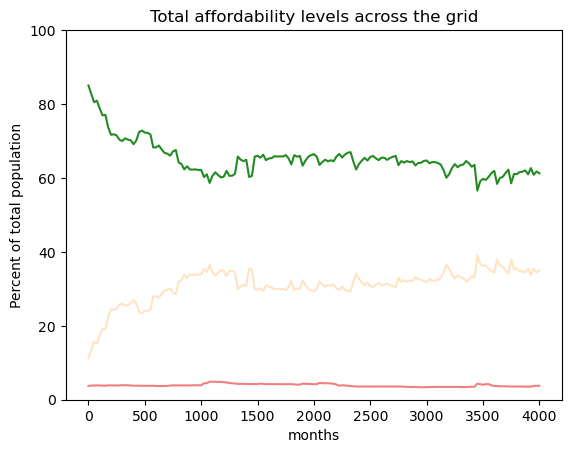

LEGEND
greeny-blue = affordable (< 5%)
browny-yellow = unaffordable (> 5%)
reds = disconnected


In [83]:
graph_grid_wide_affordability(vector, MaxIter, True)

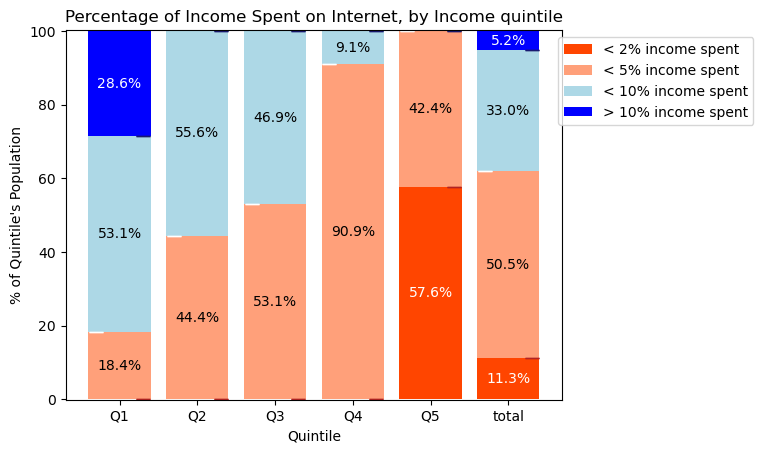

In [84]:
graph_aff_by_quint_run_avg_with_err(vector, MaxIter-1)

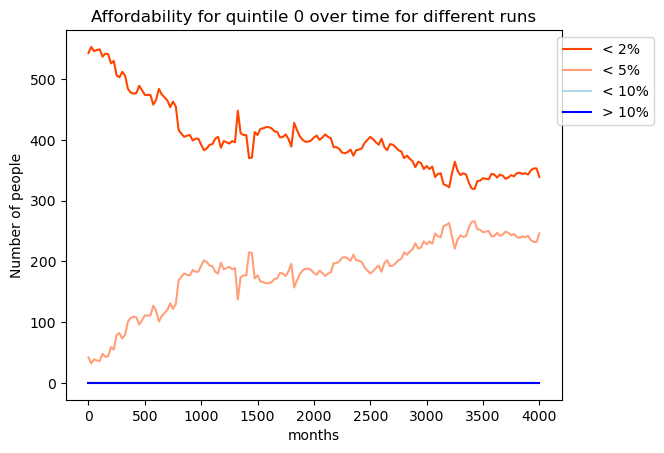

In [85]:
quintile = 0
graph_aff_by_quint_over_time(vector, quintile-1, MaxIter)

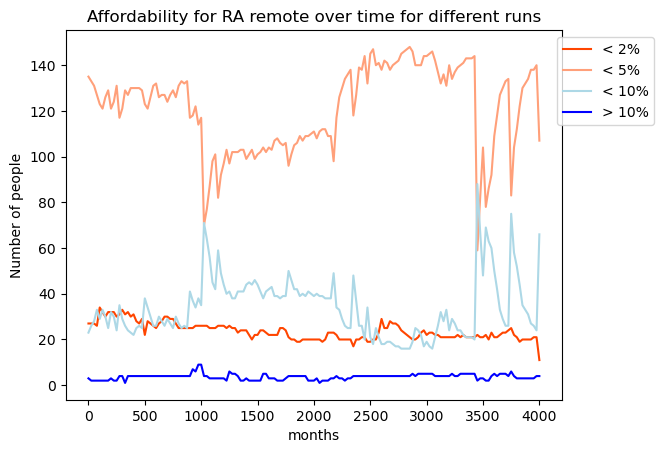

In [86]:
ra = 2
graph_aff_by_ra_over_time(vector, ra, MaxIter)

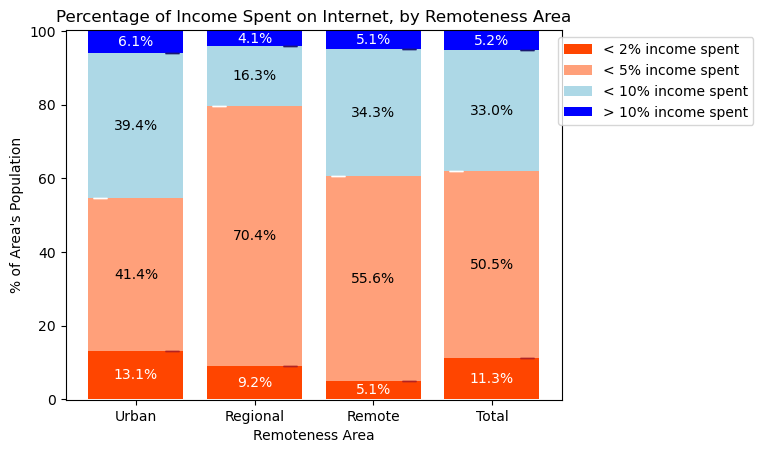

In [87]:
graph_aff_by_ra_run_avg_with_err(vector, MaxIter-1)

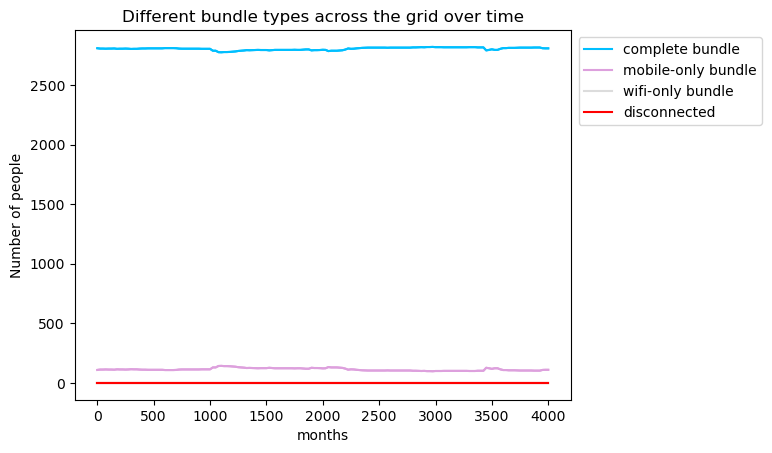

In [88]:
graph_all_bundle_types(vector, MaxIter)

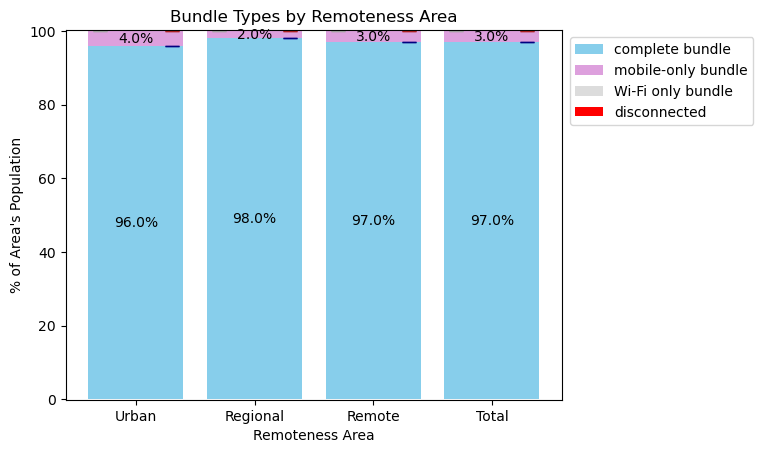

In [89]:
graph_bundles_by_ra(vector, MaxIter-1)

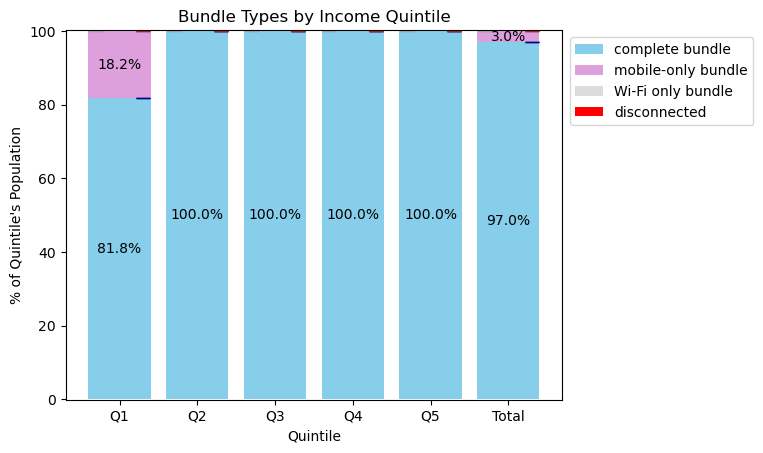

In [90]:
graph_bundles_by_quintile(vector, MaxIter-1)

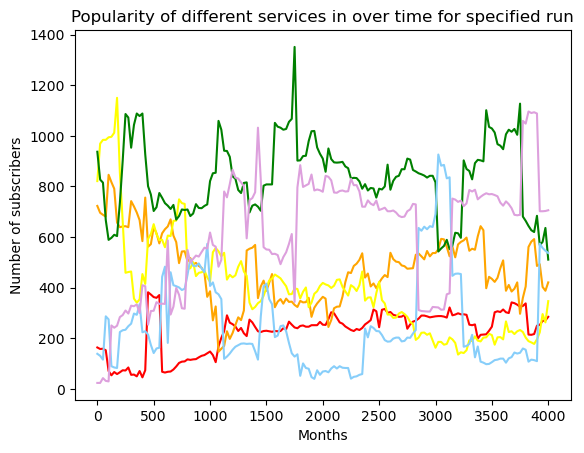

In [91]:
#can graph on four settings:
# setting 0 = (0, None) -> graph every run, every NBN speed tier
# setting 1 = (1, *r*) -> graph every NBN speed tier for run r (runs between 0 to num_runs)
# setting 2 = (2, *t*) -> graph every run, NBN speed tier t (speed teirs 0 to 5)
# setting 3 = (3, (*r*, *t*)) -> graph run r, speed tier t only
graph_subs_over_time(vector, MaxIter, (1, 0))

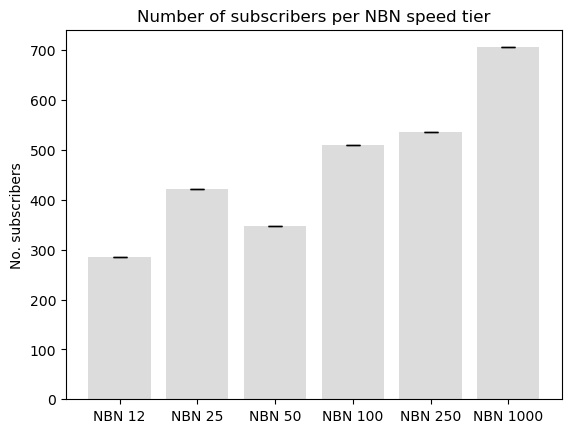

In [92]:
graph_subs(vector, MaxIter-1)

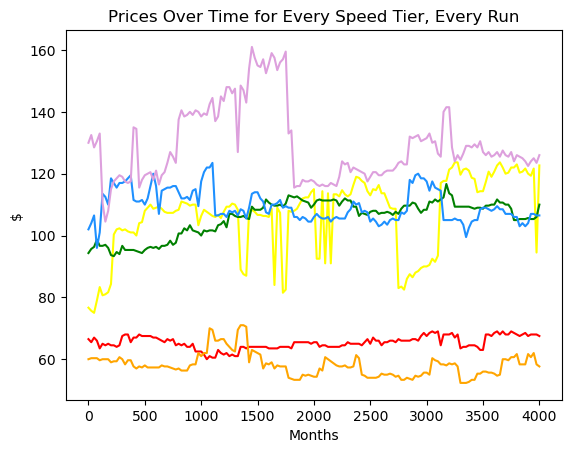

In [93]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all speed tiers
# setting 1: (1, r) -> graph run r all speed tiers (r between 0-num_runs)
# setting 2: (2, t) -> graph all runs speed tier t (t between 0-5)
graph_wifi_prices_over_time_grid_wide(vector, MaxIter, (0, None))

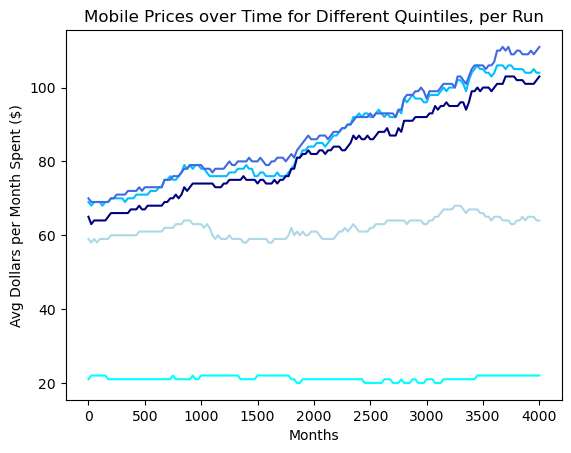

In [94]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all quintiles
# setting 1: (1, r) -> graph run r all quintiles
# setting 2: (2, q) -> graph all runs quintile q
graph_mobile_quintile_prices_over_time(vector, MaxIter, (0, 7))

[110622  44040     61]


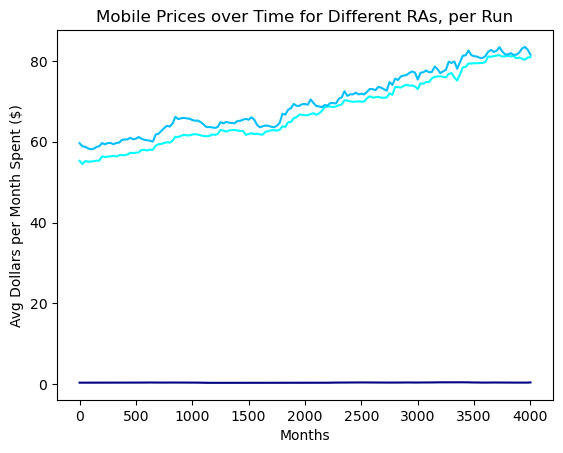

In [95]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all quintiles
# setting 1: (1, r) -> graph run r all quintiles
# setting 2: (2, q) -> graph all runs quintile q
graph_mobile_ra_prices_over_time(vector, MaxIter, (0, 4))

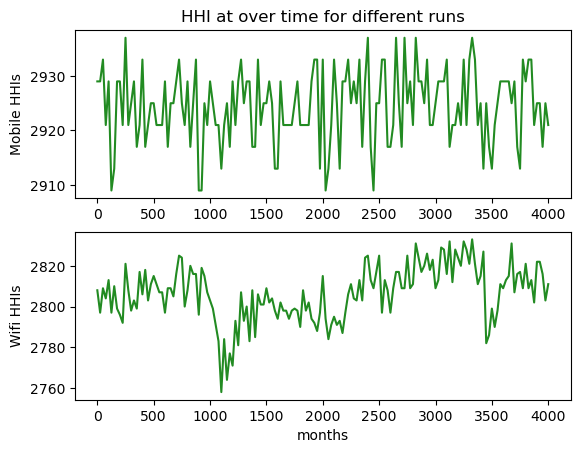

In [96]:
graph_HHIs(vector, MaxIter)

In [17]:
def graph_grid_wide_affordability(vector, MaxIter, norm_by_pop=False):
    aff_by_quint = [data[1]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    green_colours = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "lightcyan", "paleturquoise", "darkslategray", "teal", "darkcyan", "c", "cyan", "darkturquoise", "cadetblue", "powderblue", "lightblue"]
    yellow_colours = ["bisque", "darkorange", "burlywood", "antiquewhite", "tan", "navajowhite", "blanchedalmond", "papayawhip", "moccasin", "orange", "wheat", "oldlace", "darkgoldenrod", "goldenrod", "cornsilk", "gold", "kahki", "palegoldenrod", "yellow", "beige", "lemonchiffon", "darkkhaki"]
    red_colours = ["lightcoral", "indianred", "brown", "firebrick", "red", "mistyrose", "salmon", "tomato", "darksalmon", "orangered", "crimson", "deeppink", "hotpink", "mediumvioletred", "saddlebrown", "maroon", "darkred", "lightpink", "pink", "palevioletred", "chocolate"]
    
    for run in range(len(aff_by_quint)):
        y1 = [] #affordable 
        y2 = [] #affordability stress
        y3 = [] #more than 10% (including single service and disconnected)
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][0][0] + aff_by_quint[run][timestep][0][1])
            y2.append(aff_by_quint[run][timestep][0][2] + aff_by_quint[run][timestep][0][3])
            y3.append(aff_by_quint[run][timestep][0][4] + aff_by_quint[run][timestep][0][5])
            for quintile in range(1, 5):
                y1[-1] += (aff_by_quint[run][timestep][quintile][0] + aff_by_quint[run][timestep][quintile][1])
                y2[-1] += (aff_by_quint[run][timestep][quintile][2] + aff_by_quint[run][timestep][quintile][3])
                y3[-1] += (aff_by_quint[run][timestep][quintile][4] + aff_by_quint[run][timestep][quintile][5])
        if norm_by_pop:
            population = data[11]
            for i in range(len(y1)):
                y1[i] = y1[i]/population * 100
                y2[i] = y2[i]/population * 100
                y3[i] = y3[i]/population * 100
        plt.plot(x, y1, color=green_colours[run], linestyle="solid")
        plt.plot(x, y2, color=yellow_colours[run], linestyle="solid")
        plt.plot(x, y3, color=red_colours[run], linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title(f"Total affordability levels across the grid")
    if norm_by_pop:
        plt.ylabel("Percent of total population")
        plt.ylim(0, 100)
    plt.show()
    print("LEGEND\ngreeny-blue = affordable (< 5%)\nbrowny-yellow = unaffordable (> 5%)\nreds = disconnected")
    
    
def graph_aff_by_quint_run_avg_with_err(vector, timestep):
    aff_by_quints = [data[1]]
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    divisor = len(aff_by_quints)
    
    # Sum the values for each quintile and category i across all runs
    for run in aff_by_quints:
        for quintile in range(5):
            for i in range(4):
                avgs[quintile][i] += run[timestep][quintile][i]
            for i in range(4, 6):
                avgs[quintile][3] += run[timestep][quintile][i]
    
    # Calculate the average for each quintile and category i
    for quintile in range(5):
        for i in range(4):
            avgs[quintile][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for quintile in range(5):
        for i in range(3):
            values = [run[timestep][quintile][i] for run in aff_by_quints]
            std_devs[quintile][i] = np.std(values)
        values = [run[timestep][quintile][3] + run[timestep][quintile][4] + run[timestep][quintile][5] for run in aff_by_quints]
        std_devs[quintile][3] = np.std(values)
    
    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "total"]
    under_2 = np.array([0, 0, 0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0, 0, 0])
    
    under_2_err = np.array([0, 0, 0, 0, 0, 0])
    under_5_err = np.array([0, 0, 0, 0, 0, 0])
    under_10_err = np.array([0, 0, 0, 0, 0, 0])
    over_10_err = np.array([0, 0, 0, 0, 0, 0])
    
    for quint in range(5):
        for i in range(4):
            if i == 0:
                under_2[quint] = avgs[quint][i]
                under_2_err[quint] = std_devs[quint][i]
                under_2[-1] += avgs[quint][i]
                under_2_err[-1] += std_devs[quint][i] ** 2  # Sum of variances
            if i == 1:
                under_5[quint] = avgs[quint][i]
                under_5_err[quint] = std_devs[quint][i]
                under_5[-1] += avgs[quint][i]
                under_5_err[-1] += std_devs[quint][i] ** 2
            if i == 2:
                under_10[quint] = avgs[quint][i]
                under_10_err[quint] = std_devs[quint][i]
                under_10[-1] += avgs[quint][i]
                under_10_err[-1] += std_devs[quint][i] ** 2
            if i == 3:
                over_10[quint] = avgs[quint][i]
                over_10_err[quint] = std_devs[quint][i]
                over_10[-1] += avgs[quint][i]
                over_10_err[-1] += std_devs[quint][i] ** 2
    
    # Finalise total errors, normalise by population
    under_2_err[-1] = np.sqrt(under_2_err[-1])
    under_5_err[-1] = np.sqrt(under_5_err[-1])
    under_10_err[-1] = np.sqrt(under_10_err[-1])
    over_10_err[-1] = np.sqrt(over_10_err[-1])
    
    totals = [0, 0, 0, 0, 0, 0]
    for q in range(6):
        totals[q] = under_2[q] + under_5[q] + under_10[q] + over_10[q]
                
    for q in range(6):
        under_2[q] = under_2[q] / totals[q] * 100
        under_5[q] = under_5[q] / totals[q] * 100
        under_10[q] = under_10[q] / totals[q] * 100
        over_10[q] = over_10[q] / totals[q] * 100
        
        under_2_err[q] = under_2_err[q] / totals[q] * 100
        under_5_err[q] = under_5_err[q] / totals[q] * 100
        under_10_err[q] = under_10_err[q] / totals[q] * 100
        over_10_err[q] = over_10_err[q] / totals[q] * 100
        
    under_2 = np.array(under_2, dtype=float)
    under_5 = np.array(under_5, dtype=float)
    under_10 = np.array(under_10, dtype=float)
    over_10 = np.array(over_10, dtype=float)
    
    for q in range(6):
        total = under_2[q] + under_5[q] + under_10[q] + over_10[q]
        if total != 100:
            amount_to_add = 100-total
            under_2[q] = float(under_2[q]) + under_2[q]/total * amount_to_add
            under_5[q] = float(under_5[q]) + under_5[q]/total * amount_to_add
            under_10[q] = float(under_10[q]) + under_10[q]/total * amount_to_add
            over_10[q] = float(over_10[q]) + over_10[q]/total * amount_to_add

    # finding cumulative errors in between bars
    between_2_5 = np.sqrt(under_2_err ** 2 + (0.5*under_5_err) ** 2)
    between_5_10 = np.sqrt((0.5*under_5_err) ** 2 + (0.5*under_10_err) ** 2)
    between_10_10 = np.sqrt((0.5*under_10_err) ** 2 + over_10_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_2_5_start_points = []
    for i in range(len(under_2)):
        if under_2[i] - between_2_5[i] < 0:
            between_2_5_start_points.append(0 + between_2_5[i])
        elif under_2[i] + between_2_5[i] > 100:
            between_2_5_start_points.append(100 - between_2_5[i])
        else:
            between_2_5_start_points.append(under_2[i])     
    between_5_10_start_points = []
    for i in range(len(under_5)):
        if (under_2[i] + under_5[i]) - between_5_10[i] < 0:
            between_5_10_start_points.append(0 + between_5_10[i])
        elif (under_2[i] + under_5[i]) + between_5_10[i] > 100:
            between_5_10_start_points.append(100 - between_5_10[i])
        else:
            between_5_10_start_points.append(under_2[i] + under_5[i]) 
    between_10_10_start_points = []
    for i in range(len(under_10)):
        if (under_2[i] + under_5[i] + under_10[i]) - between_10_10[i] < 0:
            between_10_10_start_points.append(0 + between_10_10[i])
        elif (under_2[i] + under_5[i] + under_10[i]) + between_10_10[i] > 100:
            between_10_10_start_points.append(100 - between_10_10[i])
        else:
            between_10_10_start_points.append(under_2[i] + under_5[i] + under_10[i])
            
    plt.bar(x, under_2, label="< 2% income spent", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="< 5% income spent", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2 + under_5, label="< 10% income spent", color='lightblue')
    plt.bar(x, over_10, bottom=under_2 + under_5 + under_10, label="> 10% income spent", color='blue')
    #adding percentages printed
    for i in range(len(x)):
        if under_2[i] > 0:
            plt.text(i, under_2[i] / 2, f'{under_2[i]:.1f}%', ha='center', va='center', color='white')
        if under_5[i] > 0:
            plt.text(i, under_2[i] + (under_5[i] / 2), f'{under_5[i]:.1f}%', ha='center', va='center', color='black')
        if under_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + (under_10[i] / 2), f'{under_10[i]:.1f}%', ha='center', va='center', color='black')
        if over_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + under_10[i] + (over_10[i] / 2), f'{over_10[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_2_5_start_points, yerr=between_2_5, fmt='none', ecolor='firebrick', capsize=5)
    plt.errorbar(x_indices - 0.3, between_5_10_start_points, yerr=between_5_10, fmt='none', ecolor='white', capsize=5)
    plt.errorbar(x_indices + 0.3, between_10_10_start_points, yerr=between_10_10, fmt='none', ecolor='midnightblue', capsize=5)

    plt.title("Percentage of Income Spent on Internet, by Income quintile")
    plt.xlabel("Quintile")
    plt.ylabel("% of Quintile's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_aff_by_quint_over_time(vector, quintile, MaxIter):
    aff_by_quint = [data[1]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    labels = ["< 2%", "< 5%", "< 10%", "> 10%"]
                
    for run in range(1):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][quintile][0])
            y2.append(aff_by_quint[run][timestep][quintile][1])
            y3.append(aff_by_quint[run][timestep][quintile][2])
            y4.append(aff_by_quint[run][timestep][quintile][3])
        plt.plot(x, y1, color="orangered", label=labels[0], linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", label=labels[1], linestyle="solid")
        plt.plot(x, y3, color="lightblue", label=labels[2], linestyle="solid")
        plt.plot(x, y4, color="blue", label=labels[3], linestyle="solid")
    for run in range(1, len(aff_by_quint)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][quintile][0])
            y2.append(aff_by_quint[run][timestep][quintile][1])
            y3.append(aff_by_quint[run][timestep][quintile][2])
            y4.append(aff_by_quint[run][timestep][quintile][3])
        plt.plot(x, y1, color="orangered", linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", linestyle="solid")
        plt.plot(x, y3, color="lightblue", linestyle="solid")
        plt.plot(x, y4, color="blue", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title(f"Affordability for quintile {quintile+1} over time for different runs")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")
    plt.show()


def graph_aff_by_ra_over_time(vector, ra, MaxIter):
    aff_by_ra = [data[2]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    labels = ["< 2%", "< 5%", "< 10%", "> 10%"]
                
    for run in range(1):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_ra[run][timestep][ra][0])
            y2.append(aff_by_ra[run][timestep][ra][1])
            y3.append(aff_by_ra[run][timestep][ra][2])
            y4.append(aff_by_ra[run][timestep][ra][3])
        plt.plot(x, y1, color="orangered", label=labels[0], linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", label=labels[1], linestyle="solid")
        plt.plot(x, y3, color="lightblue", label=labels[2], linestyle="solid")
        plt.plot(x, y4, color="blue", label=labels[3], linestyle="solid")
    for run in range(1, len(aff_by_ra)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_ra[run][timestep][ra][0])
            y2.append(aff_by_ra[run][timestep][ra][1])
            y3.append(aff_by_ra[run][timestep][ra][2])
            y4.append(aff_by_ra[run][timestep][ra][3])
        plt.plot(x, y1, color="orangered", linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", linestyle="solid")
        plt.plot(x, y3, color="lightblue", linestyle="solid")
        plt.plot(x, y4, color="blue", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    strings = ["urban", "regional", "remote"]
    plt.title(f"Affordability for RA {strings[ra]} over time for different runs")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")
    plt.show()

def graph_aff_by_ra_run_avg_with_err(vector, timestep):
    aff_by_ra = [data[2]]
    
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    divisor = len(aff_by_ra)
    
    # Sum the values for each quintile and category i across all runs
    for run in aff_by_ra:
        for ra in range(3):
            for i in range(4):
                avgs[ra][i] += run[timestep][ra][i]
            for i in range(4, 6):
                avgs[ra][3] += run[timestep][ra][i]
    
    # Calculate the average for each quintile and category i
    for ra in range(3):
        for i in range(4):
            avgs[ra][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for ra in range(3):
        for i in range(3):
            values = [run[timestep][ra][i] for run in aff_by_ra]
            std_devs[ra][i] = np.std(values)
        values = [run[timestep][ra][3] + run[timestep][ra][4] + run[timestep][ra][5] for run in aff_by_ra]
        std_devs[ra][3] = np.std(values)
    
    x = ["Urban", "Regional", "Remote", "Total"]
    under_2 = np.array([0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0])
    
    under_2_err = np.array([0, 0, 0, 0])
    under_5_err = np.array([0, 0, 0, 0])
    under_10_err = np.array([0, 0, 0, 0])
    over_10_err = np.array([0, 0, 0, 0])
    
    for ra in range(3):
        for i in range(4):
            if i == 0:
                under_2[ra] = avgs[ra][i]
                under_2_err[ra] = std_devs[ra][i]
                under_2[-1] += avgs[ra][i]
                under_2_err[-1] += std_devs[ra][i] ** 2  # Sum of variances
            if i == 1:
                under_5[ra] = avgs[ra][i]
                under_5_err[ra] = std_devs[ra][i]
                under_5[-1] += avgs[ra][i]
                under_5_err[-1] += std_devs[ra][i] ** 2
            if i == 2:
                under_10[ra] = avgs[ra][i]
                under_10_err[ra] = std_devs[ra][i]
                under_10[-1] += avgs[ra][i]
                under_10_err[-1] += std_devs[ra][i] ** 2
            if i == 3:
                over_10[ra] = avgs[ra][i]
                over_10_err[ra] = std_devs[ra][i]
                over_10[-1] += avgs[ra][i]
                over_10_err[-1] += std_devs[ra][i] ** 2
    
    # Finalise total errors, normalise by population
    under_2_err[-1] = np.sqrt(under_2_err[-1])
    under_5_err[-1] = np.sqrt(under_5_err[-1])
    under_10_err[-1] = np.sqrt(under_10_err[-1])
    over_10_err[-1] = np.sqrt(over_10_err[-1])
    
    totals = [0, 0, 0, 0]
    for ra in range(4):
        totals[ra] = under_2[ra] + under_5[ra] + under_10[ra] + over_10[ra]
                
    for ra in range(4):
        under_2[ra] = under_2[ra] / totals[ra] * 100
        under_5[ra] = under_5[ra] / totals[ra] * 100
        under_10[ra] = under_10[ra] / totals[ra] * 100
        over_10[ra] = over_10[ra] / totals[ra] * 100
        
        under_2_err[ra] = under_2_err[ra] / totals[ra] * 100
        under_5_err[ra] = under_5_err[ra] / totals[ra] * 100
        under_10_err[ra] = under_10_err[ra] / totals[ra] * 100
        over_10_err[ra] = over_10_err[ra] / totals[ra] * 100
        
    under_2 = np.array(under_2, dtype=float)
    under_5 = np.array(under_5, dtype=float)
    under_10 = np.array(under_10, dtype=float)
    over_10 = np.array(over_10, dtype=float)
    
    for ra in range(4):
        total = under_2[ra] + under_5[ra] + under_10[ra] + over_10[ra]
        if total != 100:
            amount_to_add = 100-total
            under_2[ra] = float(under_2[ra]) + under_2[ra]/total * amount_to_add
            under_5[ra] = float(under_5[ra]) + under_5[ra]/total * amount_to_add
            under_10[ra] = float(under_10[ra]) + under_10[ra]/total * amount_to_add
            over_10[ra] = float(over_10[ra]) + over_10[ra]/total * amount_to_add

    # finding cumulative errors in between bars
    between_2_5 = np.sqrt(under_2_err ** 2 + (0.5*under_5_err) ** 2)
    between_5_10 = np.sqrt((0.5*under_5_err) ** 2 + (0.5*under_10_err) ** 2)
    between_10_10 = np.sqrt((0.5*under_10_err) ** 2 + over_10_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_2_5_start_points = []
    for i in range(len(under_2)):
        if under_2[i] - between_2_5[i] < 0:
            between_2_5_start_points.append(0 + between_2_5[i])
        elif under_2[i] + between_2_5[i] > 100:
            between_2_5_start_points.append(100 - between_2_5[i])
        else:
            between_2_5_start_points.append(under_2[i])     
    between_5_10_start_points = []
    for i in range(len(under_5)):
        if (under_2[i] + under_5[i]) - between_5_10[i] < 0:
            between_5_10_start_points.append(0 + between_5_10[i])
        elif (under_2[i] + under_5[i]) + between_5_10[i] > 100:
            between_5_10_start_points.append(100 - between_5_10[i])
        else:
            between_5_10_start_points.append(under_2[i] + under_5[i]) 
    between_10_10_start_points = []
    for i in range(len(under_10)):
        if (under_2[i] + under_5[i] + under_10[i]) - between_10_10[i] < 0:
            between_10_10_start_points.append(0 + between_10_10[i])
        elif (under_2[i] + under_5[i] + under_10[i]) + between_10_10[i] > 100:
            between_10_10_start_points.append(100 - between_10_10[i])
        else:
            between_10_10_start_points.append(under_2[i] + under_5[i] + under_10[i])
            
    plt.bar(x, under_2, label="< 2% income spent", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="< 5% income spent", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2 + under_5, label="< 10% income spent", color='lightblue')
    plt.bar(x, over_10, bottom=under_2 + under_5 + under_10, label="> 10% income spent", color='blue')
    #adding percentages printed
    for i in range(len(x)):
        if under_2[i] > 0:
            plt.text(i, under_2[i] / 2, f'{under_2[i]:.1f}%', ha='center', va='center', color='white')
        if under_5[i] > 0:
            plt.text(i, under_2[i] + (under_5[i] / 2), f'{under_5[i]:.1f}%', ha='center', va='center', color='black')
        if under_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + (under_10[i] / 2), f'{under_10[i]:.1f}%', ha='center', va='center', color='black')
        if over_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + under_10[i] + (over_10[i] / 2), f'{over_10[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_2_5_start_points, yerr=between_2_5, fmt='none', ecolor='firebrick', capsize=5)
    plt.errorbar(x_indices - 0.3, between_5_10_start_points, yerr=between_5_10, fmt='none', ecolor='white', capsize=5)
    plt.errorbar(x_indices + 0.3, between_10_10_start_points, yerr=between_10_10, fmt='none', ecolor='midnightblue', capsize=5)

    plt.title("Percentage of Income Spent on Internet, by Remoteness Area")
    plt.xlabel("Remoteness Area")
    plt.ylabel("% of Area's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_all_bundle_types(vector, MaxIter):
    bundle_types = [data[4]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
                
    for run in range(0, len(bundle_types)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(bundle_types[run][timestep][0][0] + bundle_types[run][timestep][1][0] + bundle_types[run][timestep][2][0])
            y2.append(bundle_types[run][timestep][0][1] + bundle_types[run][timestep][1][1] + bundle_types[run][timestep][2][1])
            y3.append(bundle_types[run][timestep][0][2] + bundle_types[run][timestep][1][2] + bundle_types[run][timestep][2][2])
            y4.append(bundle_types[run][timestep][0][3] + bundle_types[run][timestep][1][3] + bundle_types[run][timestep][2][3])
        if run == 0:
            plt.plot(x, y1, color="deepskyblue", label="complete bundle", linestyle="solid")
            plt.plot(x, y2, color="plum", label="mobile-only bundle", linestyle="solid")
            plt.plot(x, y3, color="gainsboro", label="wifi-only bundle", linestyle="solid")
            plt.plot(x, y4, color="red", label="disconnected", linestyle="solid")
        plt.plot(x, y1, color="deepskyblue", linestyle="solid")
        plt.plot(x, y2, color="plum", linestyle="solid")
        plt.plot(x, y3, color="gainsboro", linestyle="solid")
        plt.plot(x, y4, color="red", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title("Different bundle types across the grid over time")
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_bundles_by_ra(vector, timestep):
    bundles_by_ra = [data[4]]
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    divisor = len(bundles_by_ra)
    
    # Sum the values for each quintile and category i across all runs
    for run in bundles_by_ra:
        for ra in range(3):
            for i in range(4):
                avgs[ra][i] += run[timestep][ra][i]
    
    # Calculate the average for each quintile and category i
    for ra in range(3):
        for i in range(4):
            avgs[ra][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for ra in range(3):
        for i in range(4):
            values = [run[timestep][ra][i] for run in bundles_by_ra]
            std_devs[ra][i] = np.std(values)
    
    x = ["Urban", "Regional", "Remote", "Total"]
    complete = np.array([0, 0, 0, 0])
    mobile = np.array([0, 0, 0, 0])
    wifi = np.array([0, 0, 0, 0])
    disconnected = np.array([0, 0, 0, 0])
    
    complete_err = np.array([0, 0, 0, 0])
    mobile_err = np.array([0, 0, 0, 0])
    wifi_err = np.array([0, 0, 0, 0])
    disconnected_err = np.array([0, 0, 0, 0])
    
    for ra in range(3):
        for i in range(4):
            if i == 0:
                complete[ra] = avgs[ra][i]
                complete_err[ra] = std_devs[ra][i]
                complete[-1] += avgs[ra][i]
                complete_err[-1] += std_devs[ra][i] ** 2  # Sum of variances
            if i == 1:
                mobile[ra] = avgs[ra][i]
                mobile_err[ra] = std_devs[ra][i]
                mobile[-1] += avgs[ra][i]
                mobile_err[-1] += std_devs[ra][i] ** 2
            if i == 2:
                wifi[ra] = avgs[ra][i]
                wifi_err[ra] = std_devs[ra][i]
                wifi[-1] += avgs[ra][i]
                wifi_err[-1] += std_devs[ra][i] ** 2
            if i == 3:
                disconnected[ra] = avgs[ra][i]
                disconnected_err[ra] = std_devs[ra][i]
                disconnected[-1] += avgs[ra][i]
                disconnected_err[-1] += std_devs[ra][i] ** 2
    
    # Finalise total errors, normalise by population
    complete_err[-1] = np.sqrt(complete_err[-1])
    mobile_err[-1] = np.sqrt(mobile_err[-1])
    wifi_err[-1] = np.sqrt(wifi_err[-1])
    disconnected_err[-1] = np.sqrt(disconnected_err[-1])
    
    totals = [0, 0, 0, 0]
    for ra in range(4):
        totals[ra] = complete[ra] + mobile[ra] + wifi[ra] + disconnected[ra]
                
    for ra in range(4):
        complete[ra] = complete[ra] / totals[ra] * 100
        mobile[ra] = mobile[ra] / totals[ra] * 100
        wifi[ra] = wifi[ra] / totals[ra] * 100
        disconnected[ra] = disconnected[ra] / totals[ra] * 100
        
        complete_err[ra] = complete_err[ra] / totals[ra] * 100
        mobile_err[ra] = mobile_err[ra] / totals[ra] * 100
        wifi_err[ra] = wifi_err[ra] / totals[ra] * 100
        disconnected_err[ra] = disconnected_err[ra] / totals[ra] * 100
        
    complete = np.array(complete, dtype=float)
    mobile = np.array(mobile, dtype=float)
    wifi = np.array(wifi, dtype=float)
    disconnected = np.array(disconnected, dtype=float)
    
    for ra in range(4):
        total = complete[ra] + mobile[ra] + wifi[ra] + disconnected[ra]
        if total != 100:
            amount_to_add = 100-total
            complete[ra] = float(complete[ra]) + complete[ra]/total * amount_to_add
            mobile[ra] = float(mobile[ra]) + mobile[ra]/total * amount_to_add
            wifi[ra] = float(wifi[ra]) + wifi[ra]/total * amount_to_add
            disconnected[ra] = float(disconnected[ra]) + disconnected[ra]/total * amount_to_add

    # finding cumulative errors in between bars
    between_c_m = np.sqrt(complete_err ** 2 + (0.5*mobile_err) ** 2)
    between_m_w = np.sqrt((0.5*mobile_err) ** 2 + (0.5*wifi_err) ** 2)
    between_w_d = np.sqrt((0.5*wifi_err) ** 2 + disconnected_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_c_m_start_points = []
    for i in range(len(complete)):
        if complete[i] - between_c_m[i] < 0:
            between_c_m_start_points.append(0 + between_c_m[i])
        elif complete[i] + between_c_m[i] > 100:
            between_c_m_start_points.append(100 - between_c_m[i])
        else:
            between_c_m_start_points.append(complete[i])     
    between_m_w_start_points = []
    for i in range(len(mobile)):
        if (complete[i] + mobile[i]) - between_m_w[i] < 0:
            between_m_w_start_points.append(0 + between_m_w[i])
        elif (complete[i] + mobile[i]) + between_m_w[i] > 100:
            between_m_w_start_points.append(100 - between_m_w[i])
        else:
            between_m_w_start_points.append(complete[i] + mobile[i]) 
    between_w_d_start_points = []
    for i in range(len(wifi)):
        if (complete[i] + mobile[i] + wifi[i]) - between_w_d[i] < 0:
            between_w_d_start_points.append(0 + between_w_1d[i])
        elif (complete[i] + mobile[i] + wifi[i]) + between_w_d[i] > 100:
            between_w_d_start_points.append(100 - between_w_d[i])
        else:
            between_w_d_start_points.append(complete[i] + mobile[i] + wifi[i])
            
    plt.bar(x, complete, label="complete bundle", color='skyblue')
    plt.bar(x, mobile, bottom=complete, label="mobile-only bundle", color='plum')
    plt.bar(x, wifi, bottom=complete + mobile, label="Wi-Fi only bundle", color='gainsboro')
    plt.bar(x, disconnected, bottom=complete + mobile + wifi, label="disconnected", color='red')
    #adding percentages printed
    for i in range(len(x)):
        if complete[i] > 0:
            plt.text(i, complete[i] / 2, f'{complete[i]:.1f}%', ha='center', va='center', color='black')
        if mobile[i] > 0:
            plt.text(i, complete[i] + (mobile[i] / 2), f'{mobile[i]:.1f}%', ha='center', va='center', color='black')
        if wifi[i] > 0:
            plt.text(i, complete[i] + mobile[i] + (wifi[i] / 2), f'{wifi[i]:.1f}%', ha='center', va='center', color='black')
        if disconnected[i] > 0:
            plt.text(i, complete[i] + mobile[i] + wifi[i] + (disconnected[i] / 2), f'{disconnected[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_c_m_start_points, yerr=between_c_m, fmt='none', ecolor='navy', capsize=5)
    plt.errorbar(x_indices - 0.3, between_m_w_start_points, yerr=between_m_w, fmt='none', ecolor='darkgrey', capsize=5)
    plt.errorbar(x_indices + 0.3, between_w_d_start_points, yerr=between_w_d, fmt='none', ecolor='firebrick', capsize=5)

    plt.title("Bundle Types by Remoteness Area")
    plt.xlabel("Remoteness Area")
    plt.ylabel("% of Area's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_bundles_by_quintile(vector, timestep):
    bundles_by_quintile = [data[3]]
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    divisor = len(bundles_by_quintile)
    
    # Sum the values for each quintile and category i across all runs
    for run in bundles_by_quintile:
        for q in range(5):
            for i in range(4):
                avgs[q][i] += run[timestep][q][i]
    
    # Calculate the average for each quintile and category i
    for q in range(5):
        for i in range(4):
            avgs[q][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for q in range(5):
        for i in range(4):
            values = [run[timestep][q][i] for run in bundles_by_quintile]
            std_devs[q][i] = np.std(values)
    
    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "Total"]
    complete = np.array([0, 0, 0, 0, 0, 0])
    mobile = np.array([0, 0, 0, 0, 0, 0])
    wifi = np.array([0, 0, 0, 0, 0, 0])
    disconnected = np.array([0, 0, 0, 0, 0, 0])
    
    complete_err = np.array([0, 0, 0, 0, 0, 0])
    mobile_err = np.array([0, 0, 0, 0, 0, 0])
    wifi_err = np.array([0, 0, 0, 0, 0, 0])
    disconnected_err = np.array([0, 0, 0, 0, 0, 0])
    
    for q in range(5):
        for i in range(4):
            if i == 0:
                complete[q] = avgs[q][i]
                complete_err[q] = std_devs[q][i]
                complete[-1] += avgs[q][i]
                complete_err[-1] += std_devs[q][i] ** 2  # Sum of variances
            if i == 1:
                mobile[q] = avgs[q][i]
                mobile_err[q] = std_devs[q][i]
                mobile[-1] += avgs[q][i]
                mobile_err[-1] += std_devs[q][i] ** 2
            if i == 2:
                wifi[q] = avgs[q][i]
                wifi_err[q] = std_devs[q][i]
                wifi[-1] += avgs[q][i]
                wifi_err[-1] += std_devs[q][i] ** 2
            if i == 3:
                disconnected[q] = avgs[q][i]
                disconnected_err[q] = std_devs[q][i]
                disconnected[-1] += avgs[q][i]
                disconnected_err[-1] += std_devs[q][i] ** 2
    
    # Finalise total errors, normalise by population
    complete_err[-1] = np.sqrt(complete_err[-1])
    mobile_err[-1] = np.sqrt(mobile_err[-1])
    wifi_err[-1] = np.sqrt(wifi_err[-1])
    disconnected_err[-1] = np.sqrt(disconnected_err[-1])
    
    totals = [0, 0, 0, 0, 0, 0]
    for q in range(6):
        totals[q] = complete[q] + mobile[q] + wifi[q] + disconnected[q]
                
    for q in range(6):
        complete[q] = complete[q] / totals[q] * 100
        mobile[q] = mobile[q] / totals[q] * 100
        wifi[q] = wifi[q] / totals[q] * 100
        disconnected[q] = disconnected[q] / totals[q] * 100
        
        complete_err[q] = complete_err[q] / totals[q] * 100
        mobile_err[q] = mobile_err[q] / totals[q] * 100
        wifi_err[q] = wifi_err[q] / totals[q] * 100
        disconnected_err[q] = disconnected_err[q] / totals[q] * 100
        
    complete = np.array(complete, dtype=float)
    mobile = np.array(mobile, dtype=float)
    wifi = np.array(wifi, dtype=float)
    disconnected = np.array(disconnected, dtype=float)
    
    for q in range(6):
        total = complete[q] + mobile[q] + wifi[q] + disconnected[q]
        if total != 100:
            amount_to_add = 100-total
            complete[q] = float(complete[q]) + complete[q]/total * amount_to_add
            mobile[q] = float(mobile[q]) + mobile[q]/total * amount_to_add
            wifi[q] = float(wifi[q]) + wifi[q]/total * amount_to_add
            disconnected[q] = float(disconnected[q]) + disconnected[q]/total * amount_to_add

    # finding cumulative errors in between bars
    between_c_m = np.sqrt(complete_err ** 2 + (0.5*mobile_err) ** 2)
    between_m_w = np.sqrt((0.5*mobile_err) ** 2 + (0.5*wifi_err) ** 2)
    between_w_d = np.sqrt((0.5*wifi_err) ** 2 + disconnected_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_c_m_start_points = []
    for i in range(len(complete)):
        if complete[i] - between_c_m[i] < 0:
            between_c_m_start_points.append(0 + between_c_m[i])
        elif complete[i] + between_c_m[i] > 100:
            between_c_m_start_points.append(100 - between_c_m[i])
        else:
            between_c_m_start_points.append(complete[i])     
    between_m_w_start_points = []
    for i in range(len(mobile)):
        if (complete[i] + mobile[i]) - between_m_w[i] < 0:
            between_m_w_start_points.append(0 + between_m_w[i])
        elif (complete[i] + mobile[i]) + between_m_w[i] > 100:
            between_m_w_start_points.append(100 - between_m_w[i])
        else:
            between_m_w_start_points.append(complete[i] + mobile[i]) 
    between_w_d_start_points = []
    for i in range(len(wifi)):
        if (complete[i] + mobile[i] + wifi[i]) - between_w_d[i] < 0:
            between_w_d_start_points.append(0 + between_w_1d[i])
        elif (complete[i] + mobile[i] + wifi[i]) + between_w_d[i] > 100:
            between_w_d_start_points.append(100 - between_w_d[i])
        else:
            between_w_d_start_points.append(complete[i] + mobile[i] + wifi[i])
            
    plt.bar(x, complete, label="complete bundle", color='skyblue')
    plt.bar(x, mobile, bottom=complete, label="mobile-only bundle", color='plum')
    plt.bar(x, wifi, bottom=complete + mobile, label="Wi-Fi only bundle", color='gainsboro')
    plt.bar(x, disconnected, bottom=complete + mobile + wifi, label="disconnected", color='red')
    #adding percentages printed
    for i in range(len(x)):
        if complete[i] > 0:
            plt.text(i, complete[i] / 2, f'{complete[i]:.1f}%', ha='center', va='center', color='black')
        if mobile[i] > 0:
            plt.text(i, complete[i] + (mobile[i] / 2), f'{mobile[i]:.1f}%', ha='center', va='center', color='black')
        if wifi[i] > 0:
            plt.text(i, complete[i] + mobile[i] + (wifi[i] / 2), f'{wifi[i]:.1f}%', ha='center', va='center', color='black')
        if disconnected[i] > 0:
            plt.text(i, complete[i] + mobile[i] + wifi[i] + (disconnected[i] / 2), f'{disconnected[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_c_m_start_points, yerr=between_c_m, fmt='none', ecolor='navy', capsize=5)
    plt.errorbar(x_indices - 0.3, between_m_w_start_points, yerr=between_m_w, fmt='none', ecolor='darkgrey', capsize=5)
    plt.errorbar(x_indices + 0.3, between_w_d_start_points, yerr=between_w_d, fmt='none', ecolor='firebrick', capsize=5)

    plt.title("Bundle Types by Income Quintile")
    plt.xlabel("Quintile")
    plt.ylabel("% of Quintile's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_subs_over_time(vector, MaxIter, setting):
    subs = [data[5]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        
        for run_index in range(len(subs)):
            run = subs[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            y6 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0])
                y2.append(run[timestep][1])
                y3.append(run[timestep][2])
                y4.append(run[timestep][3])
                y5.append(run[timestep][4])
                y6.append(run[timestep][5])
            plt.plot(x, y1, color="red", linestyle="solid")
            plt.plot(x, y2, color="orange", linestyle="solid")
            plt.plot(x, y3, color="yellow", linestyle="solid")
            plt.plot(x, y4, color="green", linestyle="solid")
            plt.plot(x, y5, color="dodgerblue", linestyle="solid")
            plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Popularity of different services in over time")
            
    elif setting[0] == 1:

        run = subs[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        y6 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0])
            y2.append(run[timestep][1])
            y3.append(run[timestep][2])
            y4.append(run[timestep][3])
            y5.append(run[timestep][4])
            y6.append(run[timestep][5])
        plt.plot(x, y1, color="red", label="NBN 12", linestyle="solid")
        plt.plot(x, y2, color="orange", label="NBN 25", linestyle="solid")
        plt.plot(x, y3, color="yellow", label="NBN 50", linestyle="solid")
        plt.plot(x, y4, color="green", label="NBN 100", linestyle="solid")
        plt.plot(x, y5, color="lightskyblue", label="NBN 250", linestyle="solid")
        plt.plot(x, y6, color="plum", label="NBN 1000", linestyle="solid")
        
        plt.title("Popularity of different services in over time for specified run")
        
    elif setting[0] == 2:
        speed = setting[1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]

        for run_index in range(len(subs)):
            run = subs[run_index]
            y = []
            for timestep in range(len(x)):
                y.append(run[timestep][speed])
            plt.plot(x, y, color=colours[speed], linestyle="solid")
        
        plt.title("Popularity of specified speed tier over time for different runs")
        
    else:
        run = subs[setting[1][0]]
        speed = setting[1][1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]
        y = []
        for timestep in range(len(x)):
            y.append(run[timestep][speed])
        plt.plot(x, y, color=colours[speed], linestyle="solid")
        plt.title("Popularity of specified speed tier over time for specified run")
        
    plt.xlabel("Months")
    plt.ylabel("Number of subscribers")
    plt.show()
    
def graph_subs(vector, timestep):
    subs = [data[5]]
    timestep = timestep // 25
    
    avgs = [0 for _ in range(6)]
    for run in subs:
        for speed in range(6):
            avgs[speed] += run[timestep][speed]
    for avg in range(len(avgs)):
        avgs[avg] /= num_runs
    
    std_devs = [0 for _ in range(6)]
    for speed in range(6):
        values = [run[timestep][speed] for run in subs]
        std_devs[speed] = np.std(values)
    
    x = ["NBN 12", "NBN 25", "NBN 50", "NBN 100", "NBN 250", "NBN 1000"]
    plt.bar(x, avgs, color='gainsboro')
    plt.errorbar(x, avgs, yerr=std_devs, fmt='none', ecolor='black', capsize=5)
    plt.title("Number of subscribers per NBN speed tier")
    plt.ylabel("No. subscribers")
    plt.show()

    
def graph_wifi_prices_over_time_grid_wide(vector, MaxIter, setting):
    prices = [data[6]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
                 
    if setting[0] == 0:
        
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            y6 = []
            for timestep in range(len(x)):
                avgs = [0, 0, 0, 0, 0, 0]
                nums = [0, 0, 0, 0, 0, 0]
                for ra in range(3):
                    for speed in range(6):
                        if run[timestep][ra][speed] != 0:
                            avgs[speed] += run[timestep][ra][speed]
                            nums[speed] += 1
                for speed in range(6):
                    if nums[speed] > 0:
                        avgs[speed] /= nums[speed]
                y1.append(avgs[0])
                y2.append(avgs[1])
                y3.append(avgs[2])
                y4.append(avgs[3])
                y5.append(avgs[4])
                y6.append(avgs[5])
            plt.plot(x, y1, color="red", linestyle="solid")
            plt.plot(x, y2, color="orange", linestyle="solid")
            plt.plot(x, y3, color="yellow", linestyle="solid")
            plt.plot(x, y4, color="green", linestyle="solid")
            plt.plot(x, y5, color="dodgerblue", linestyle="solid")
            plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Prices Over Time for Every Speed Tier, Every Run")
        
    elif setting[0] == 1:

        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        y6 = []
        for timestep in range(len(x)):
            avgs = [0, 0, 0, 0, 0, 0]
            nums = [0, 0, 0, 0, 0, 0]
            for ra in range(3):
                for speed in range(6):
                    if run[timestep][ra][speed] != 0:
                        avgs[speed] += run[timestep][ra][speed]
                        nums[speed] += 1
            for speed in range(6):
                if nums[speed] > 0:
                    avgs[speed] /= nums[speed]
            y1.append(avgs[0])
            y2.append(avgs[1])
            y3.append(avgs[2])
            y4.append(avgs[3])
            y5.append(avgs[4])
            y6.append(avgs[5])
        plt.plot(x, y1, color="red", linestyle="solid")
        plt.plot(x, y2, color="orange", linestyle="solid")
        plt.plot(x, y3, color="yellow", linestyle="solid")
        plt.plot(x, y4, color="green", linestyle="solid")
        plt.plot(x, y5, color="dodgerblue", linestyle="solid")
        plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Prices Over Time for Every Speed Tier, Specified Run")
        
    else:
        speed = setting[1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            for timestep in range(len(x)):
                avg = 0
                num = 0
                for ra in range(3):
                    if run[timestep][ra][speed] != 0:
                        avg += run[timestep][ra][speed]
                        num += 1
                if num > 0:
                    avg /= num
                y.append(avg)
            plt.plot(x, y, color=colours[speed], linestyle="solid")
        
        plt.title("Prices Over Time for Specified Speed Tier, Every Run")
    
    plt.xlabel("Months")
    plt.ylabel("$")
    plt.show()
    
def graph_mobile_quintile_prices_over_time(vector, MaxIter, setting):
    prices = [data[8]]
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0])
                y2.append(run[timestep][1])
                y3.append(run[timestep][2])
                y4.append(run[timestep][3])
                y5.append(run[timestep][4])
            plt.plot(x, y1, color="cyan", linestyle="solid")
            plt.plot(x, y2, color="lightblue", linestyle="solid")
            plt.plot(x, y3, color="deepskyblue", linestyle="solid")
            plt.plot(x, y4, color="royalblue", linestyle="solid")
            plt.plot(x, y5, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different Quintiles, per Run")
        
    elif setting[0] == 1:
        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0])
            y2.append(run[timestep][1])
            y3.append(run[timestep][2])
            y4.append(run[timestep][3])
            y5.append(run[timestep][4])
        plt.plot(x, y1, color="cyan", linestyle="solid")
        plt.plot(x, y2, color="lightblue", linestyle="solid")
        plt.plot(x, y3, color="deepskyblue", linestyle="solid")
        plt.plot(x, y4, color="royalblue", linestyle="solid")
        plt.plot(x, y5, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different Quintiles, for the Specified Run")
        
    else:
        q = setting[1]
        colours = ["cyan", "lightblue", "deepskyblue", "royalblue", "navy"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            for timestep in range(len(x)):
                y.append(run[timestep][q])
            plt.plot(x, y, color=colours[q], linestyle="solid")
        
        plt.title("Mobile Prices over Time for Specified Quintile, per Run")
        
        
    plt.xlabel("Months")
    plt.ylabel("Avg Dollars per Month Spent ($)")
    plt.show()
    
def graph_mobile_ra_prices_over_time(vector, MaxIter, setting):
    prices = [data[7]]
    print(prices[0][6])
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0]/2000)
                y2.append(run[timestep][1]/750)
                y3.append(run[timestep][2]/170)
            plt.plot(x, y1, color="cyan", linestyle="solid")
            plt.plot(x, y2, color="deepskyblue", linestyle="solid")
            plt.plot(x, y3, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different RAs, per Run")
        
    elif setting[0] == 1:
        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0]/2000)
            y2.append(run[timestep][1]/750)
            y3.append(run[timestep][2]/170)
        plt.plot(x, y1, color="cyan", linestyle="solid")
        plt.plot(x, y2, color="deepskyblue", linestyle="solid")
        plt.plot(x, y3, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different RAs, for the Specified Run")
        
    else:
        q = setting[1]
        colours = ["cyan", "deepskyblue", "navy"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            divs = [2000, 750, 170]
            for timestep in range(len(x)):
                y.append(run[timestep][q]/divs[q])
            plt.plot(x, y, color=colours[q], linestyle="solid")
        
        plt.title("Mobile Prices over Time for Specified RA, per Run")
        
        
    plt.xlabel("Months")
    plt.ylabel("Avg Dollars per Month Spent ($)")
    plt.show()
    
def graph_HHIs(vector, MaxIter):
    HHIs = [data[9]]
    plot1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1, colspan=1)
    plot2 = plt.subplot2grid((2, 1), (1, 0), rowspan=1, colspan=1)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    colours = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "lightcyan", "paleturquoise", "darkslategray", "teal", "darkcyan", "c", "cyan", "darkturquoise", "cadetblue", "powderblue", "lightblue"]
    
    for run in range(len(HHIs)):
        y1 = []
        y2 = []
        for timestep in range(len(x)):
            y1.append(HHIs[run][timestep][0])
            y2.append(HHIs[run][timestep][1])
        plot1.plot(x, y1, color=colours[run], linestyle="solid")
        plot2.plot(x, y2, color=colours[run], linestyle="solid")

    plot2.set_xlabel("months")
    plot1.set_ylabel("Mobile HHIs")
    plot2.set_ylabel("Wifi HHIs")
    plot1.set_title("HHI at over time for different runs")
    plt.show()